In [1]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import glob
from sncosmo.salt2utils import BicubicInterpolator
from matplotlib.ticker import ScalarFormatter
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
import sncosmo
from scipy.interpolate import interp1d
from numpy import random
import pickle as pk
from astropy.table import Table
from sncosmo.constants import HC_ERG_AA
from sklearn import preprocessing
from scipy.linalg import block_diag
from scipy.stats import ks_2samp

SCALE_FACTOR = 1e-12

In [3]:
# PCA class from sklearn does not perfom complete Scaling (i.e. transform the data to zero mean and unit variance column(features) wise)
# This class perfom only centering by mean, column wise. 

In [4]:
plt.rcParams['font.size'] = 20.

In [5]:
class ScalarFormatterClass1(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

In [6]:
p_grid=np.arange(-10,51,1)
w_grid_reg=np.arange(3310,8585,10) 

In [7]:
X, Y=np.meshgrid(p_grid,w_grid_reg)

## Retrieve Data and Define Train/Validation samples

In [8]:
snnames=[]
for file in glob.glob("../Applying_GPy/SEDs_reg_normalized/*.dat"):
    snnames.append(file.split("/")[3].split(".")[0])

In [9]:
len(snnames)

166

In [10]:
val_sn, train_sn=train_test_split(snnames, test_size=0.9, train_size=0.1, random_state=0)

In [11]:
train_names=[]
train_data=[]
train_data_err=[]

In [12]:
val_names=[]
val_data=[]
val_data_err=[]

In [13]:
for sn in snnames:
    if sn in val_sn:
        val_data.append(pd.read_csv(f"../Applying_GPy/SEDs_reg_normalized/{sn}.dat")["flux"].values)
        val_data_err.append(pd.read_csv(f"../Applying_GPy/SEDs_reg_normalized/{sn}.dat")["fluxerr"].values)
        val_names.append(sn)
    else:
        train_data.append(pd.read_csv(f"../Applying_GPy/SEDs_reg_normalized/{sn}.dat")["flux"].values)
        train_data_err.append(pd.read_csv(f"../Applying_GPy/SEDs_reg_normalized/{sn}.dat")["fluxerr"].values)
        train_names.append(sn)

In [14]:
val_names

['Train_SN51_v2_SED_normalized',
 'Test_SN23_v2_SED_normalized',
 'Test_SN44_v2_SED_normalized',
 'Test_SN8_v2_SED_normalized',
 'Train_SN106_v2_SED_normalized',
 'Train_SN78_v2_SED_normalized',
 'Test_SN21_v2_SED_normalized',
 'Train_SN53_v2_SED_normalized',
 'Test_SN39_v2_SED_normalized',
 'Train_SN95_v2_SED_normalized',
 'Test_SN42_v2_SED_normalized',
 'Train_SN121_v2_SED_normalized',
 'Train_SN83_v2_SED_normalized',
 'Train_SN115_v2_SED_normalized',
 'Train_SN116_v2_SED_normalized',
 'Train_SN108_v2_SED_normalized']

In [15]:
train_names

['Test_SN2_v2_SED_normalized',
 'Train_SN6_v2_SED_normalized',
 'Train_SN68_v2_SED_normalized',
 'Test_SN29_v2_SED_normalized',
 'Train_SN37_v2_SED_normalized',
 'Test_SN20_v2_SED_normalized',
 'Train_SN90_v2_SED_normalized',
 'Train_SN105_v2_SED_normalized',
 'Train_SN55_v2_SED_normalized',
 'Train_SN3_v2_SED_normalized',
 'Train_SN9_v2_SED_normalized',
 'Test_SN47_v2_SED_normalized',
 'Train_SN56_v2_SED_normalized',
 'Train_SN94_v2_SED_normalized',
 'Test_SN32_v2_SED_normalized',
 'Train_SN5_v2_SED_normalized',
 'Train_SN62_v2_SED_normalized',
 'Train_SN24_v2_SED_normalized',
 'Train_SN91_v2_SED_normalized',
 'Train_SN52_v2_SED_normalized',
 'Test_SN7_v2_SED_normalized',
 'Test_SN43_v2_SED_normalized',
 'Test_SN18_v2_SED_normalized',
 'Test_SN46_v2_SED_normalized',
 'Train_SN69_v2_SED_normalized',
 'Train_SN99_v2_SED_normalized',
 'Train_SN54_v2_SED_normalized',
 'Train_SN101_v2_SED_normalized',
 'Train_SN21_v2_SED_normalized',
 'Test_SN17_v2_SED_normalized',
 'Train_SN19_v2_SED_norm

## Apply PCA

In [16]:
pca=PCA()
pca.fit(train_data)

PCA()

In [17]:
X_train_pca=pca.transform(train_data)
X_val_pca=pca.transform(val_data)

In [18]:
pca.components_.shape

(150, 32208)

In [19]:
X_train_pca.shape

(150, 150)

In [20]:
X_train_pca[:,:2].shape

(150, 2)

## View Explained Variance

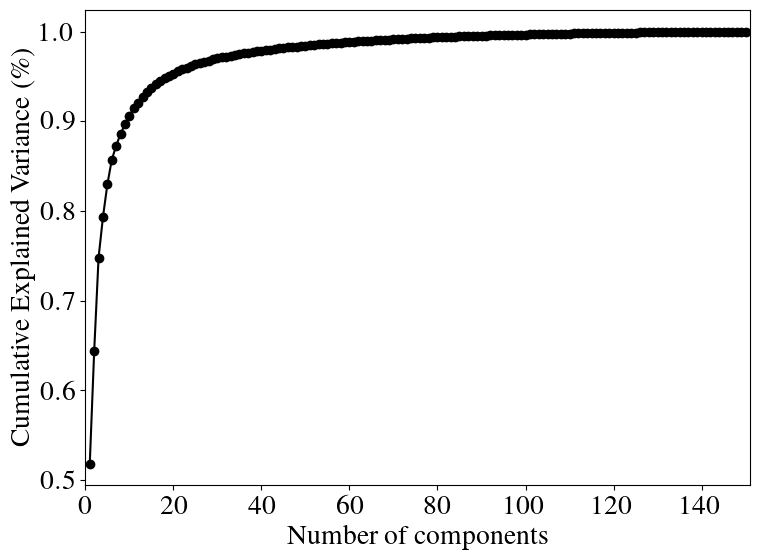

In [21]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(np.linspace(1,150,150),np.cumsum(pca.explained_variance_ratio_),"-o",c="black")
ax.set_xlim(0,151)
ax.set_xticks(np.arange(0,151,20))
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative Explained Variance (\\%)")
fig.tight_layout()

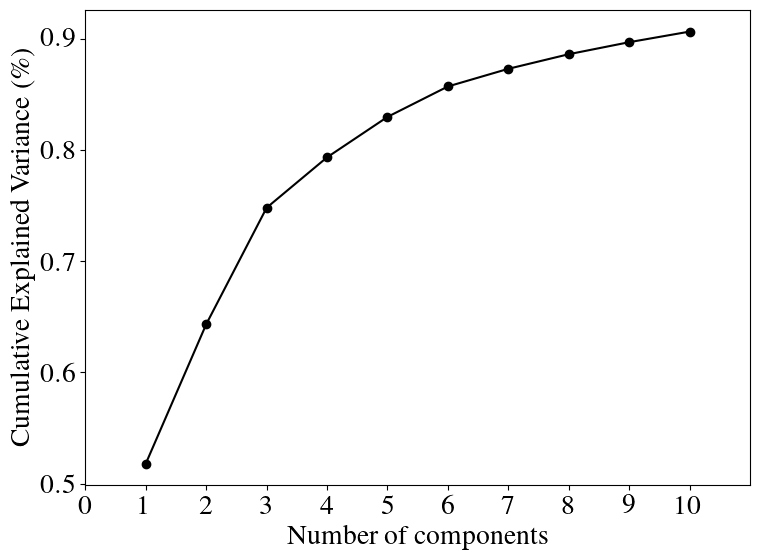

In [22]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(np.linspace(1,10,10),np.cumsum(pca.explained_variance_ratio_)[:10],"-o",c="black")
ax.set_xlim(0,11)
ax.set_xticks(np.arange(11))
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative Explained Variance (\\%)")
fig.tight_layout()
plt.savefig('./pca_figures/cum_explained_variance.png',dpi=300, facecolor="white")  

In [23]:
np.cumsum(pca.explained_variance_ratio_)

array([0.51804002, 0.6432601 , 0.74796078, 0.79325555, 0.82959283,
       0.85694198, 0.87281086, 0.88592463, 0.89672587, 0.90624633,
       0.91474841, 0.9208892 , 0.9267572 , 0.93215818, 0.93715926,
       0.94125027, 0.9448709 , 0.94789673, 0.95058562, 0.95319326,
       0.95557891, 0.95780221, 0.95986024, 0.96163286, 0.96332351,
       0.96482563, 0.96623931, 0.96763013, 0.96887719, 0.97004577,
       0.97115976, 0.97216748, 0.97312825, 0.97403337, 0.97490647,
       0.97574754, 0.97656603, 0.97730472, 0.9780234 , 0.9787288 ,
       0.97938301, 0.98000726, 0.98061732, 0.98119896, 0.98177953,
       0.98232585, 0.98286158, 0.98337405, 0.9838715 , 0.98435686,
       0.98483175, 0.98529169, 0.98573068, 0.9861616 , 0.98656112,
       0.98695632, 0.98734445, 0.98771638, 0.98807184, 0.98841538,
       0.98875208, 0.98907118, 0.98938575, 0.98968669, 0.98998664,
       0.99028016, 0.99056112, 0.99083847, 0.99110574, 0.99136442,
       0.99161607, 0.99186204, 0.99210584, 0.99234626, 0.99257

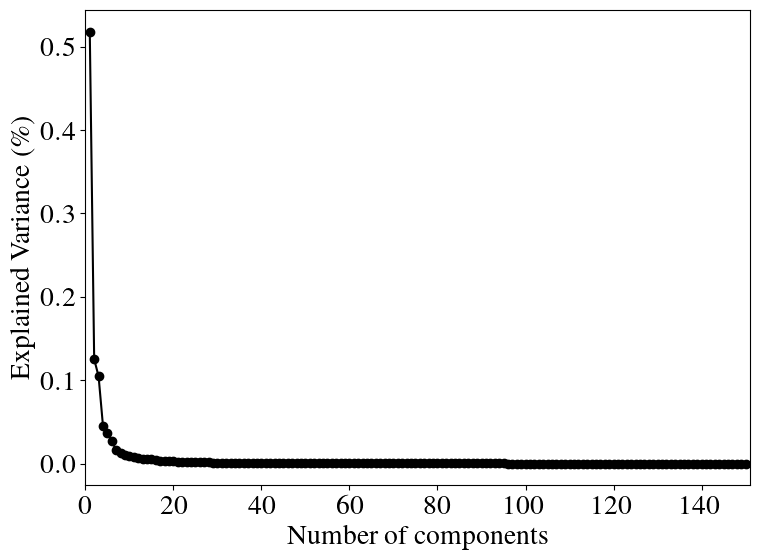

In [24]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(np.linspace(1,150,150),pca.explained_variance_ratio_,"-o",c="black")
ax.set_xlim(0,151)
ax.set_xticks(np.arange(0,151,20))
ax.set_xlabel("Number of components")
ax.set_ylabel("Explained Variance (\\%)")
fig.tight_layout()

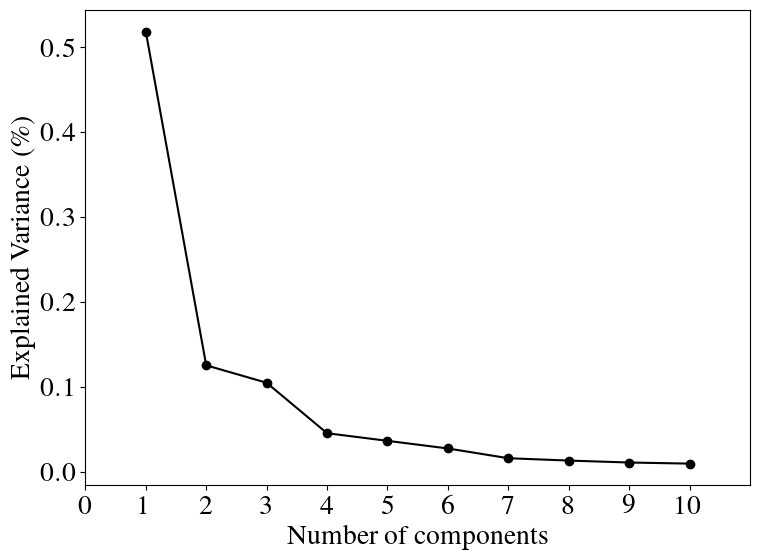

In [25]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(np.linspace(1,10,10),pca.explained_variance_ratio_[:10],"-o",c="black")
ax.set_xlim(0,11)
ax.set_xticks(np.arange(11))
ax.set_xlabel("Number of components")
ax.set_ylabel("Explained Variance (\\%)")
fig.tight_layout()
plt.savefig('./pca_figures/explained_variance.png',dpi=300, facecolor="white")  

## Visualize Surface Reconstruction

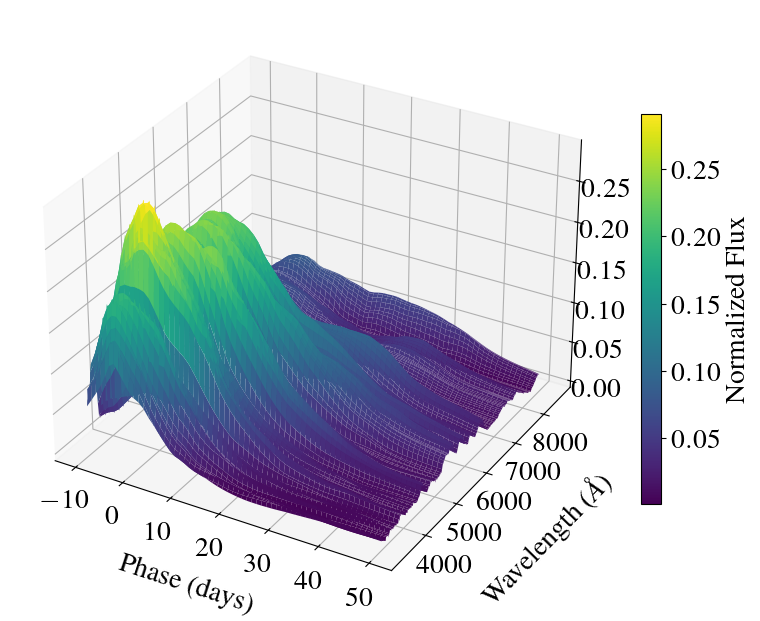

In [26]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,pca.mean_.reshape(X.shape)+np.dot(X_val_pca,pca.components_)[0].reshape(X.shape),cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="Normalized Flux")
fig.tight_layout()
plt.show()

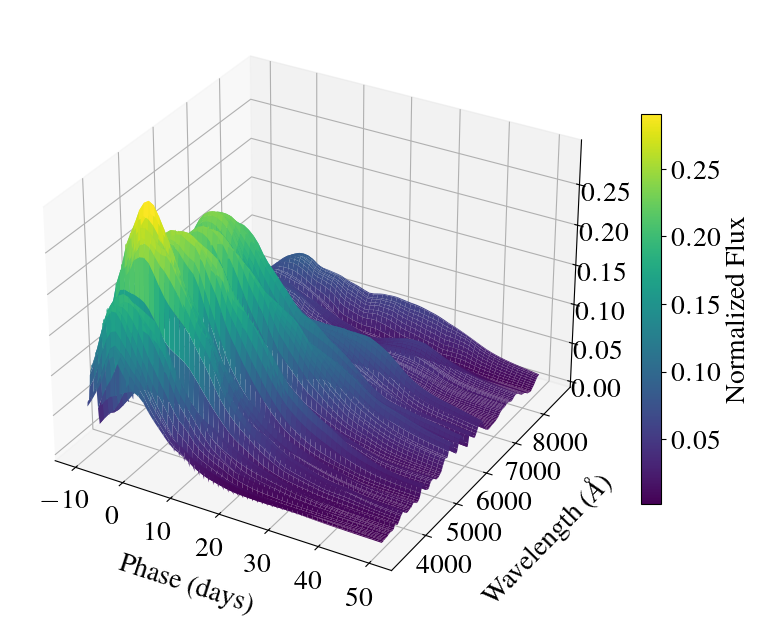

In [27]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,val_data[0].reshape(X.shape),cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="Normalized Flux")
fig.tight_layout()
plt.show()

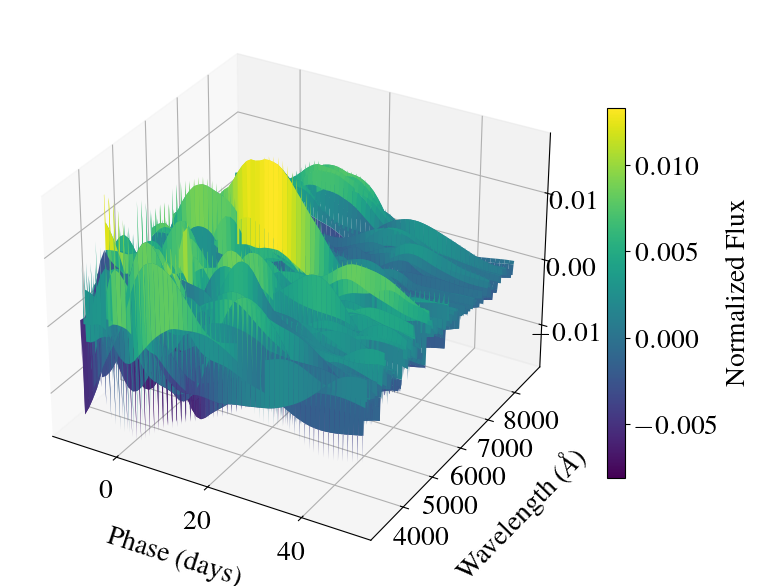

In [28]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,val_data[0].reshape(X.shape)-(pca.mean_.reshape(X.shape)+np.dot(X_val_pca,pca.components_)[0].reshape(X.shape)),cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="Normalized Flux")
fig.tight_layout()
plt.show()

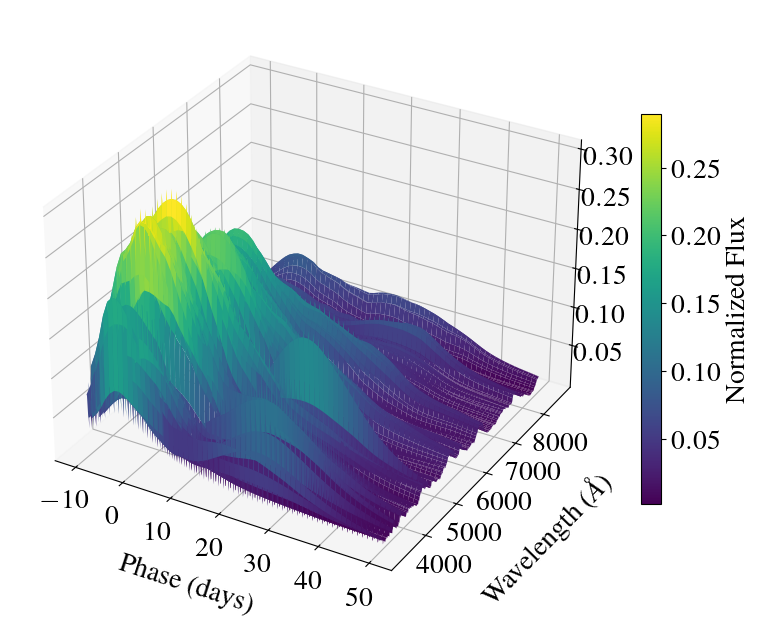

In [29]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,pca.mean_.reshape(X.shape)+np.dot(X_train_pca,pca.components_)[0].reshape(X.shape),cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="Normalized Flux")
fig.tight_layout()
plt.show()

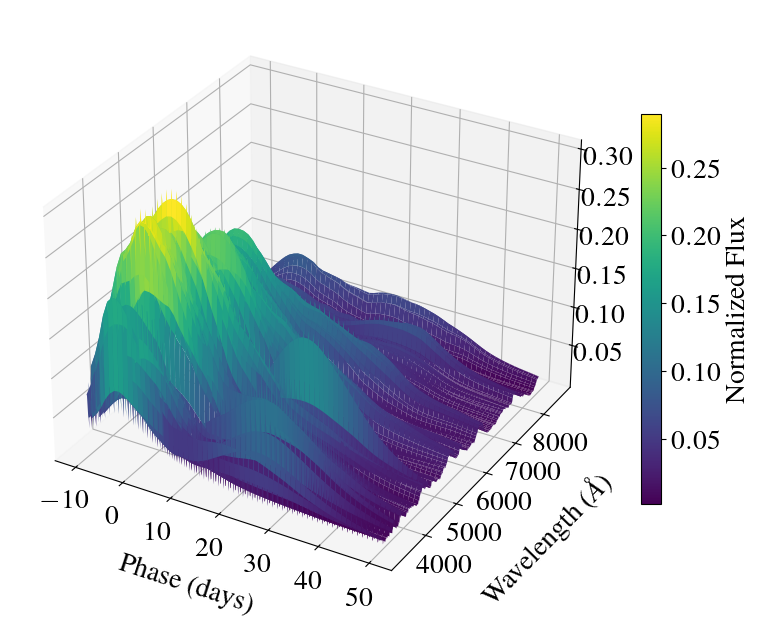

In [30]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,train_data[0].reshape(X.shape),cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="Normalized Flux")
fig.tight_layout()
plt.show()

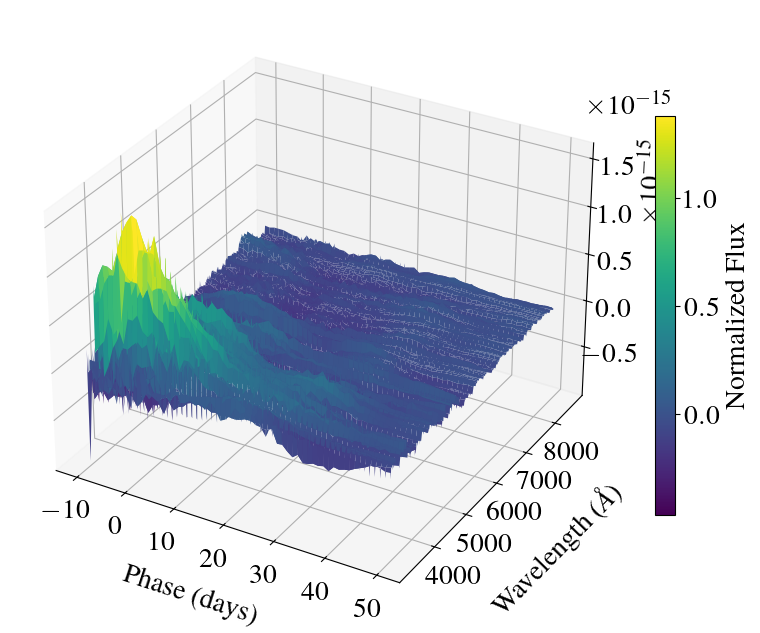

In [31]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,train_data[0].reshape(X.shape)-(pca.mean_.reshape(X.shape)+np.dot(X_train_pca,pca.components_)[0].reshape(X.shape)),cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="Normalized Flux")
fig.tight_layout()
plt.show()

## Compute Surface Reconstruction Discrepancy

In [32]:
# The total squared error in a reconstruction equals the sum of the discard eigenvalues
#for i in range(1,len(train_data)+1):
#    s=0
#    for j in range(len(train_data)):
#        dat=train_data[j]
#        reconst_dat= pca.mean_+np.dot(X_train_pca[:,:i],pca.components_[:i])[j]
#        dif=dat-reconst_dat
#        s+=np.dot(dif,dif)
#    print(s)
#    print((len(train_data)-1)*np.sum(pca.explained_variance_[i:])) 

In [33]:
train_se=[] # train sample squared error
for i in range(1,len(train_data)+1):
    s=0
    for j in range(len(train_data)):
        dat=train_data[j]
        reconst_dat= pca.mean_+np.dot(X_train_pca[:,:i],pca.components_[:i])[j]
        dif=dat-reconst_dat
        s+=np.dot(dif,dif)
    train_se.append(s/len(train_data)) # dividing by the sample size

In [34]:
val_se=[] # test sample squared error
for i in range(1,len(train_data)+1):
    s=0
    for j in range(len(val_data)):
        dat=val_data[j]
        reconst_dat= pca.mean_+np.dot(X_val_pca[:,:i],pca.components_[:i])[j]
        dif=dat-reconst_dat
        s+=np.dot(dif,dif)
    val_se.append(s/len(val_data)) # dividing by the sample size

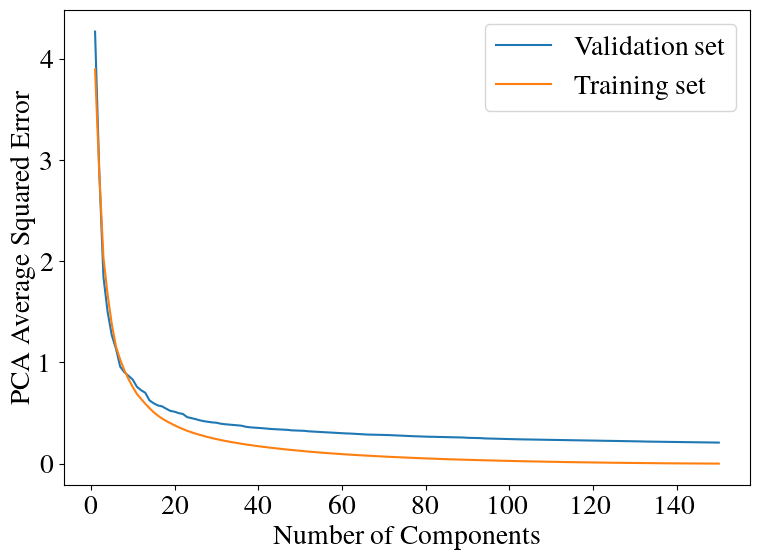

In [35]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(range(1,len(train_data)+1),val_se,label="Validation set")
ax.plot(range(1,len(train_data)+1),train_se,label="Training set")
ax.set_ylabel("PCA Average Squared Error") # units of squared normalized flux 
ax.set_xticks(np.arange(0,len(train_data),20))
ax.set_xlabel("Number of Components")
ax.legend()
fig.tight_layout();

In [36]:
train_se=[] 
for i in range(1,len(train_data)+1):
    s=0
    for j in range(len(train_data)):
        dat=train_data[j]
        dat_err=train_data_err[j]
        reconst_dat= pca.mean_+np.dot(X_train_pca[:,:i],pca.components_[:i])[j]
        dif=(dat-reconst_dat)/dat_err
        s+=np.dot(dif,dif)
    train_se.append(s/len(train_data)) # dividing by the sample size

In [37]:
val_se=[]
for i in range(1,len(train_data)+1):
    s=0
    for j in range(len(val_data)):
        dat=val_data[j]
        dat_err=val_data_err[j]
        reconst_dat= pca.mean_+np.dot(X_val_pca[:,:i],pca.components_[:i])[j]
        dif=(dat-reconst_dat)/dat_err
        s+=np.dot(dif,dif)
    val_se.append(s/len(val_data)) # dividing by the sample size

In [38]:
len(val_data[0])

32208

In [39]:
ndof=np.array([32208]*150)-np.arange(1,151)

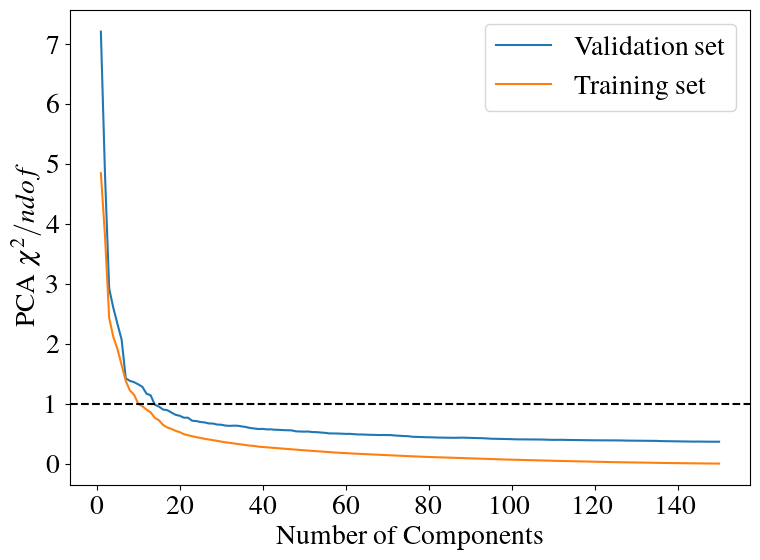

In [40]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(range(1,len(train_data)+1),np.array(val_se)/ndof,label="Validation set")
ax.plot(range(1,len(train_data)+1),np.array(train_se)/ndof,label="Training set")
ax.set_ylabel(r"PCA $\chi^2/ndof$") 
ax.set_xticks(np.arange(0,len(train_data),20))
ax.set_xlabel("Number of Components")
ax.axhline(y=1., color='black', linestyle='--')
ax.legend()
fig.tight_layout()
plt.savefig('./pca_figures/pca_reconst_chi2ndof.png',dpi=300, facecolor="white");

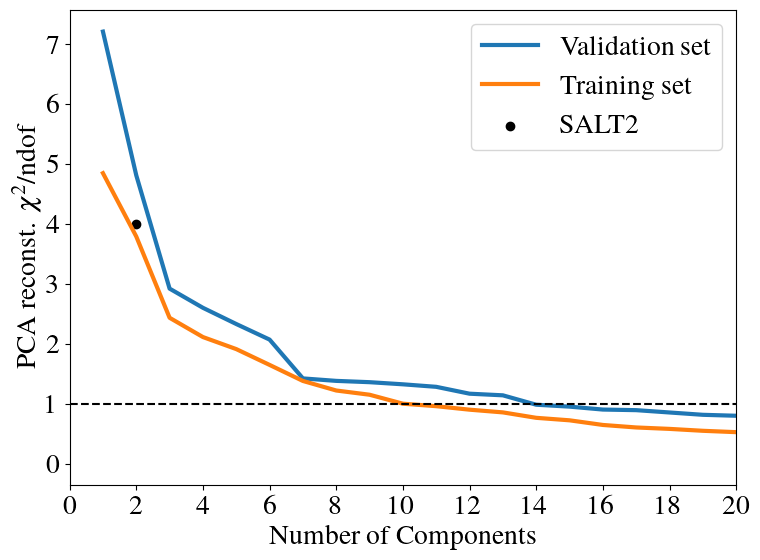

In [41]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(range(1,len(train_data)+1),np.array(val_se)/ndof,label="Validation set",lw=3.)
ax.plot(range(1,len(train_data)+1),np.array(train_se)/ndof,label="Training set",lw=3.)
ax.scatter([2],[4.0],label="SALT2",marker='o',c='black')
ax.set_ylabel(r"PCA reconst. $\chi^2$/ndof") 
ax.set_xticks(np.arange(0,21,2))
ax.set_xlim(0,20)
ax.set_xlabel("Number of Components")
ax.axhline(y=1., color='black', linestyle='--')
ax.legend()
fig.tight_layout()
plt.savefig('./pca_figures/pca_reconst_chi2ndof.png',dpi=300, facecolor="white");

In [42]:
disc_mean_val=[]
disc_median_val=[]
for i in range(1,len(train_data)+1):
    fraction=[]
    for j in range(len(val_data)):
        dat=val_data[j]
        reconst_dat= pca.mean_+np.dot(X_val_pca[:,:i],pca.components_[:i])[j]
        fraction.append(np.mean(abs((dat-reconst_dat)/dat)*100))
    disc_mean_val.append(np.mean(fraction))
    disc_median_val.append(np.median(fraction))

In [43]:
disc_mean_train=[]
disc_median_train=[]
for i in range(1,len(train_data)+1):
    fraction=[]
    for j in range(len(train_data)):
        dat=train_data[j]
        reconst_dat= pca.mean_+np.dot(X_train_pca[:,:i],pca.components_[:i])[j]
        fraction.append(np.mean(abs((dat-reconst_dat)/dat)*100))
    disc_mean_train.append(np.mean(fraction))
    disc_median_train.append(np.median(fraction))

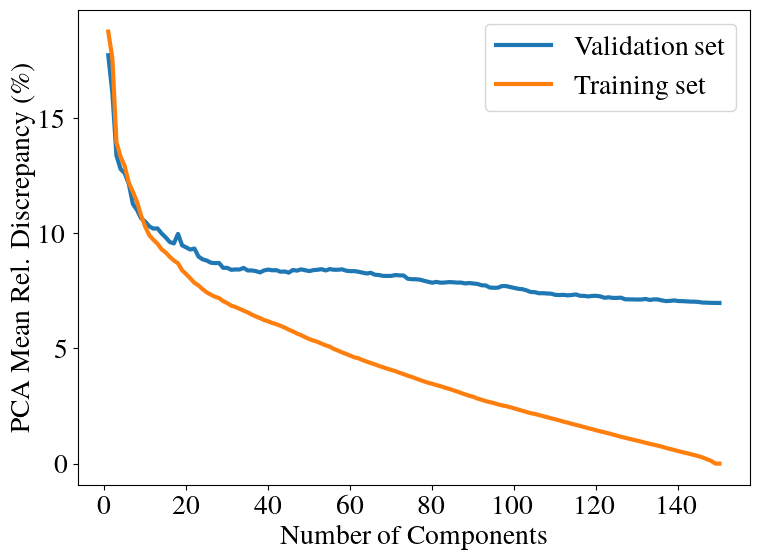

In [44]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(range(1,len(train_data)+1),disc_mean_val,label="Validation set",lw=3.)
ax.plot(range(1,len(train_data)+1),disc_mean_train,label="Training set",lw=3.)
ax.set_ylabel("PCA Mean Rel. Discrepancy (\\%)") # units of normalized flux
ax.set_xticks(np.arange(0,len(train_data),20))
ax.set_xlabel("Number of Components")
ax.legend()
fig.tight_layout()
plt.savefig('./pca_figures/mean_rel_disc.png',dpi=300, facecolor="white");

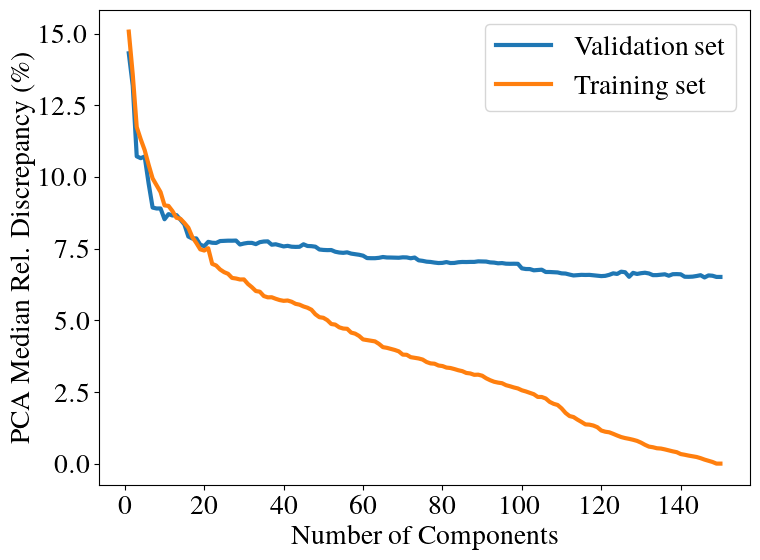

In [45]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(range(1,len(train_data)+1),disc_median_val,label="Validation set",lw=3.)
ax.plot(range(1,len(train_data)+1),disc_median_train,label="Training set",lw=3.)
ax.set_ylabel("PCA Median Rel. Discrepancy (\\%)") 
ax.set_xticks(np.arange(0,len(train_data),20))
ax.set_xlabel("Number of Components")
ax.legend()
fig.tight_layout()
plt.savefig('./pca_figures/median_rel_disc.png',dpi=300, facecolor="white")

## Store and Export PCA Components

In [28]:
M0=pca.mean_.reshape(X.shape)
M1=pca.components_[0].reshape(X.shape)
M2=pca.components_[1].reshape(X.shape)
M3=pca.components_[2].reshape(X.shape)
M4=pca.components_[3].reshape(X.shape)
M5=pca.components_[4].reshape(X.shape)
M6=pca.components_[5].reshape(X.shape)
M7=pca.components_[6].reshape(X.shape)
M8=pca.components_[7].reshape(X.shape)
M9=pca.components_[8].reshape(X.shape)
M10=pca.components_[9].reshape(X.shape)
M11=pca.components_[10].reshape(X.shape)
M12=pca.components_[11].reshape(X.shape)

In [29]:
np.savetxt("./pca_components/M0_pca.txt",M0)
np.savetxt("./pca_components/M1_pca.txt",M1)
np.savetxt("./pca_components/M2_pca.txt",M2)
np.savetxt("./pca_components/M3_pca.txt",M3)
np.savetxt("./pca_components/M4_pca.txt",M4)
np.savetxt("./pca_components/M5_pca.txt",M5)
np.savetxt("./pca_components/M6_pca.txt",M6)
np.savetxt("./pca_components/M7_pca.txt",M7)
np.savetxt("./pca_components/M8_pca.txt",M8)
np.savetxt("./pca_components/M9_pca.txt",M9)
np.savetxt("./pca_components/M10_pca.txt",M10)
np.savetxt("./pca_components/M11_pca.txt",M11)
np.savetxt("./pca_components/M12_pca.txt",M12)

## View PCA Components

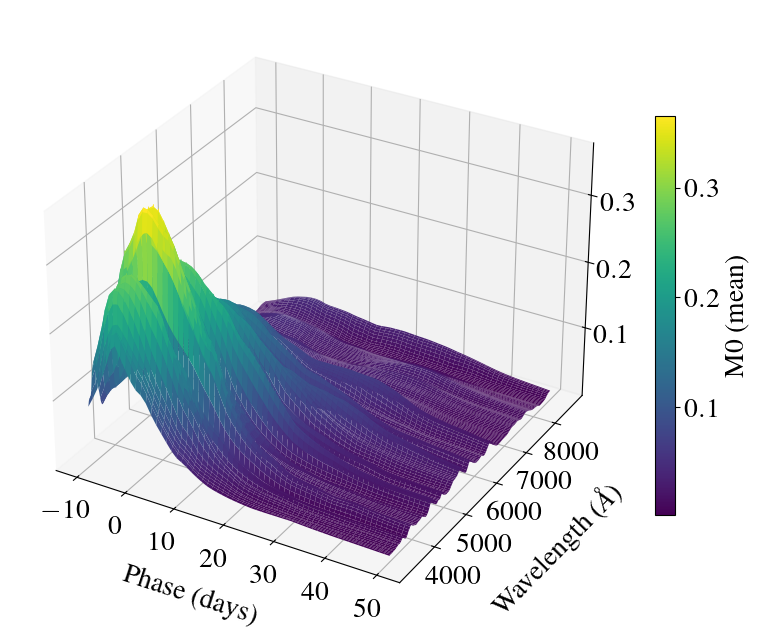

In [30]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M0,cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="M0 (mean)")
fig.tight_layout()
plt.savefig('./pca_figures/M0(mean).png', facecolor="white")  

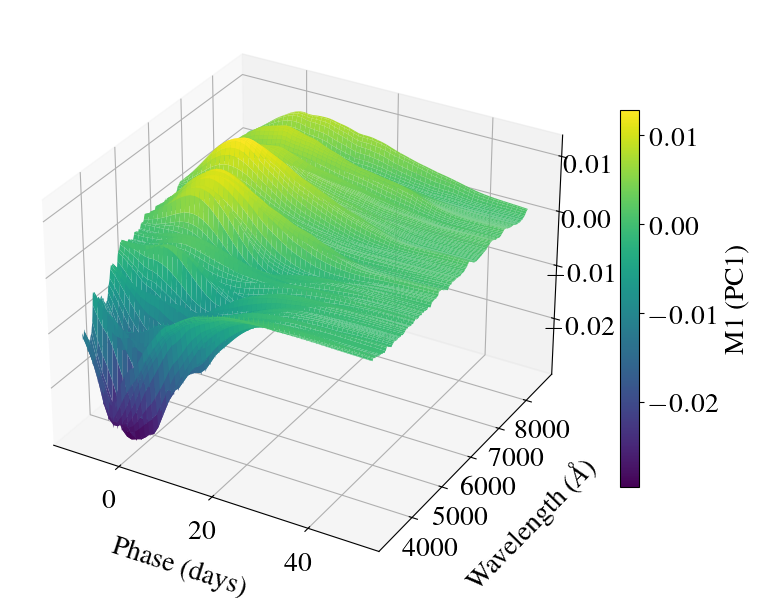

In [31]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M1,cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="M1 (PC1)")
fig.tight_layout()
plt.savefig('./pca_figures/M1(PC1).png', facecolor="white")  

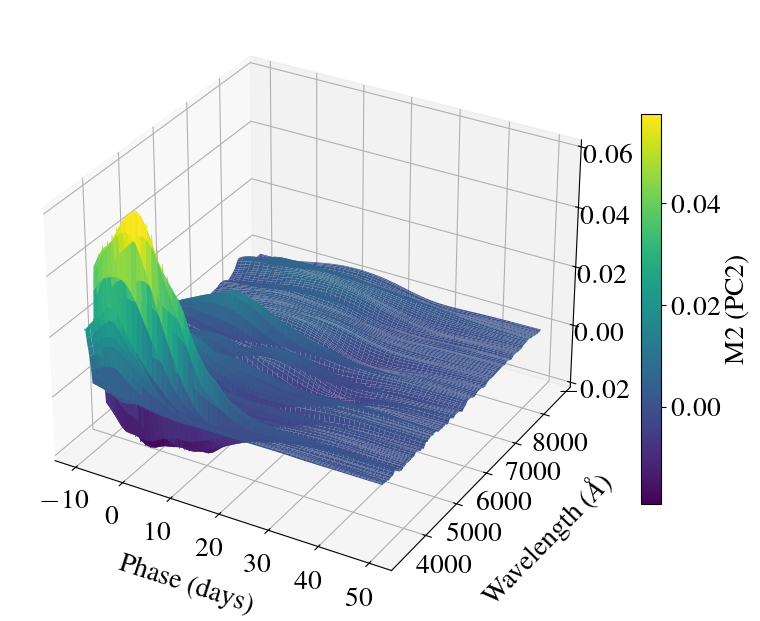

In [32]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M2,cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="M2 (PC2)")
fig.tight_layout()
plt.savefig('./pca_figures/M2(PC2).png', facecolor="white")  

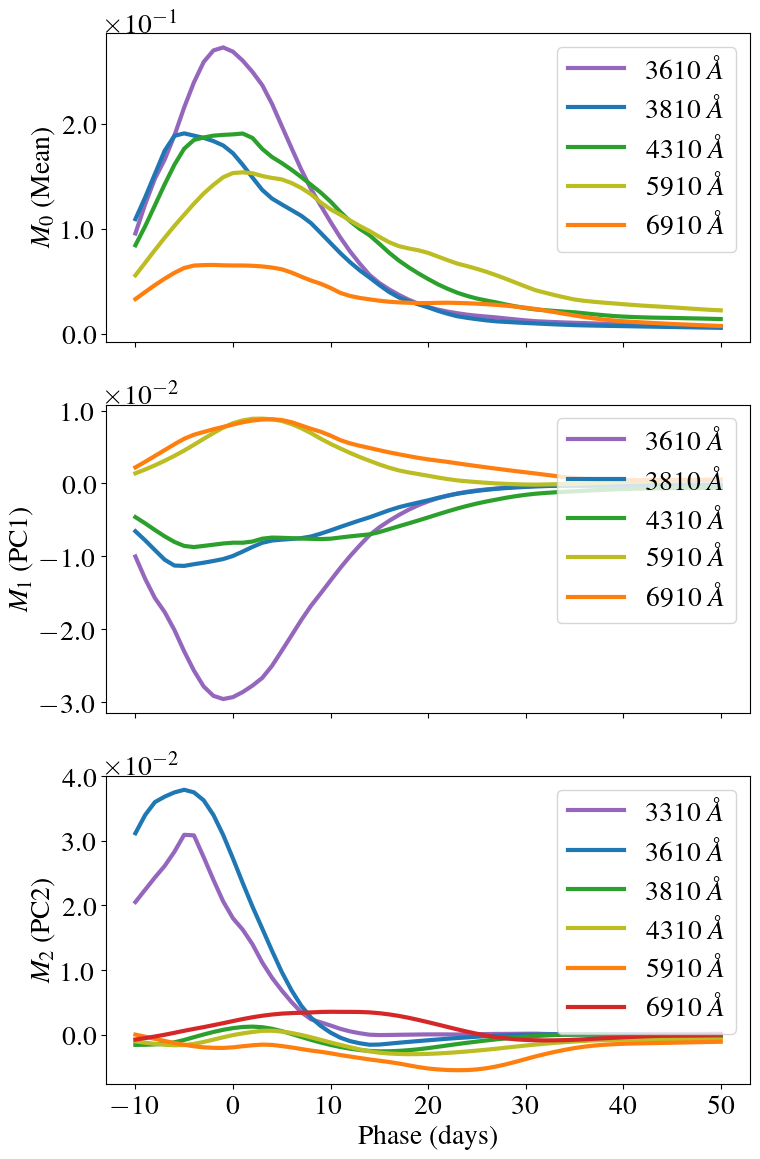

In [33]:
fig, axs = plt.subplots(3,1,figsize=(8,12),sharex=True)

colors=["C4","C0","C2","C8","C1","C3"]
for j,i in enumerate([30,50,100,260,360]):
    axs[0].plot(X[i],M0[i],label=f"{int(Y[i][0])} $\\AA$",lw=3,color=colors[j])
    axs[0].set_ylabel(r"$M_0$ (Mean)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend(loc=1)

for j,i in enumerate([30,50,100,260,360]):
    axs[1].plot(X[i],M1[i],label=f"{int(Y[i][0])} $\\AA$",lw=3,color=colors[j])
    axs[1].set_ylabel(r"$M_1$ (PC1)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[1].yaxis.set_major_formatter(formatter11)
    axs[1].legend(loc=1)

for j,i in enumerate([0,30,50,100,260,360]):
    axs[2].plot(X[i],M2[i],label=f"{int(Y[i][0])} $\\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"$M_2$ (PC2)")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[2].yaxis.set_major_formatter(formatter11)
    axs[2].legend(loc=1)

fig.tight_layout()
plt.savefig('./pca_figures/PCA_components.png',dpi=300,facecolor='white', transparent=False,bbox_inches='tight')  

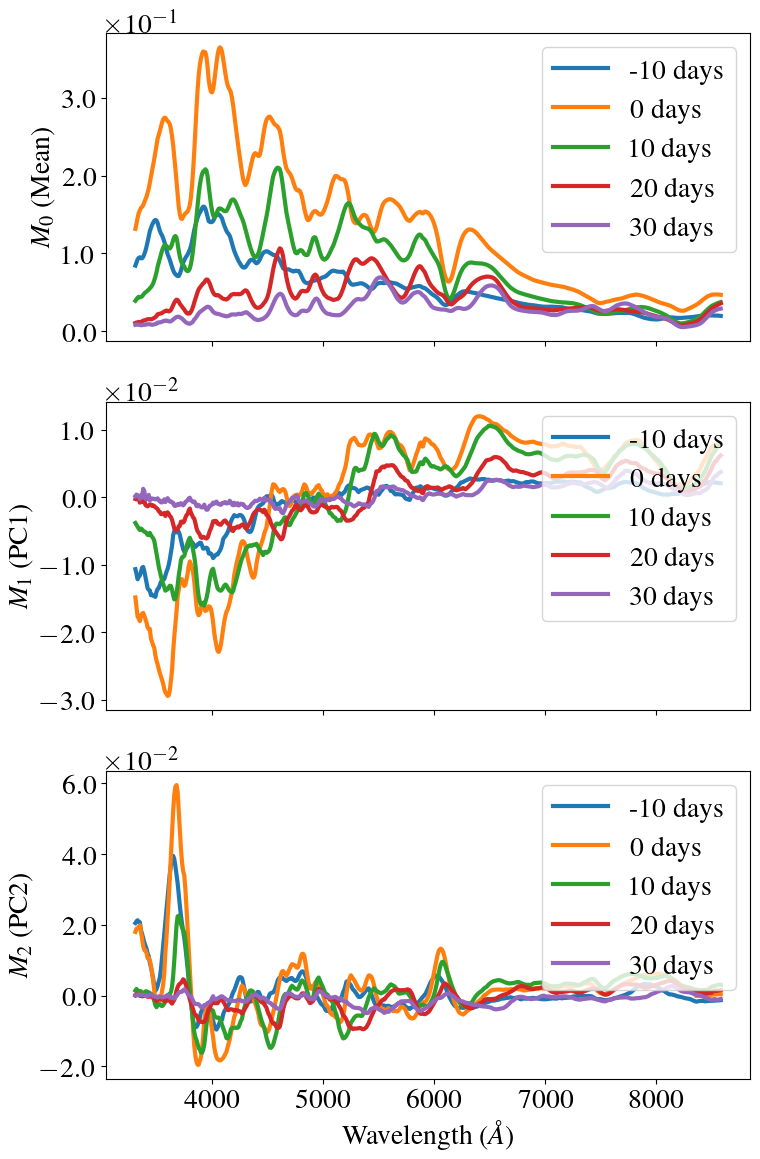

In [34]:
fig, axs = plt.subplots(3,1,figsize=(8,12),sharex=True)

colors=["C0","C1","C2","C3","C4","C5"]
for j,i in enumerate([0,10,20,30,40]):
    axs[0].plot(Y.T[i],M0.T[i],label=f"{int(X.T[i][0])} days",lw=3,color=colors[j])
    axs[0].set_ylabel(r"$M_0$ (Mean)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend(loc=1)

for j,i in enumerate([0,10,20,30,40]):
    axs[1].plot(Y.T[i],M1.T[i],label=f"{int(X.T[i][0])} days",lw=3,color=colors[j])
    axs[1].set_ylabel(r"$M_1$ (PC1)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[1].yaxis.set_major_formatter(formatter11)
    axs[1].legend(loc=1)

for j,i in enumerate([0,10,20,30,40]):
    axs[2].plot(Y.T[i],M2.T[i],label=f"{int(X.T[i][0])} days",lw=3,color=colors[j])
    axs[2].set_xlabel(r"Wavelength ($\AA$)")
    axs[2].set_ylabel(r"$M_2$ (PC2)")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[2].yaxis.set_major_formatter(formatter11)
    axs[2].legend(loc=1)

fig.tight_layout()
plt.savefig('./pca_figures/PCA_components_ph.png',dpi=300,facecolor='white', transparent=False,bbox_inches='tight')  

In [35]:
M0_g=[]
M0_b=[]
M0_v=[]
M0_r=[]
for d in range(len(X.T)):
    sp=sncosmo.Spectrum(wave=Y.T[d], flux=M0.T[d],time=X.T[d][0]) 
    M0_g.append(sp.bandflux("cspg"))
    M0_b.append(sp.bandflux("cspb"))
    M0_v.append(sp.bandflux("cspv9844"))
    M0_r.append(sp.bandflux("cspr"))

In [36]:
M1_g=[]
M1_b=[]
M1_v=[]
M1_r=[]
for d in range(len(X.T)):
    sp=sncosmo.Spectrum(wave=Y.T[d], flux=M1.T[d],time=X.T[d][0]) 
    M1_g.append(sp.bandflux("cspg"))
    M1_b.append(sp.bandflux("cspb"))
    M1_v.append(sp.bandflux("cspv9844"))
    M1_r.append(sp.bandflux("cspr"))

In [37]:
M2_g=[]
M2_b=[]
M2_v=[]
M2_r=[]
for d in range(len(X.T)):
    sp=sncosmo.Spectrum(wave=Y.T[d], flux=M2.T[d],time=X.T[d][0]) 
    M2_g.append(sp.bandflux("cspg"))
    M2_b.append(sp.bandflux("cspb"))
    M2_v.append(sp.bandflux("cspv9844"))
    M2_r.append(sp.bandflux("cspr"))

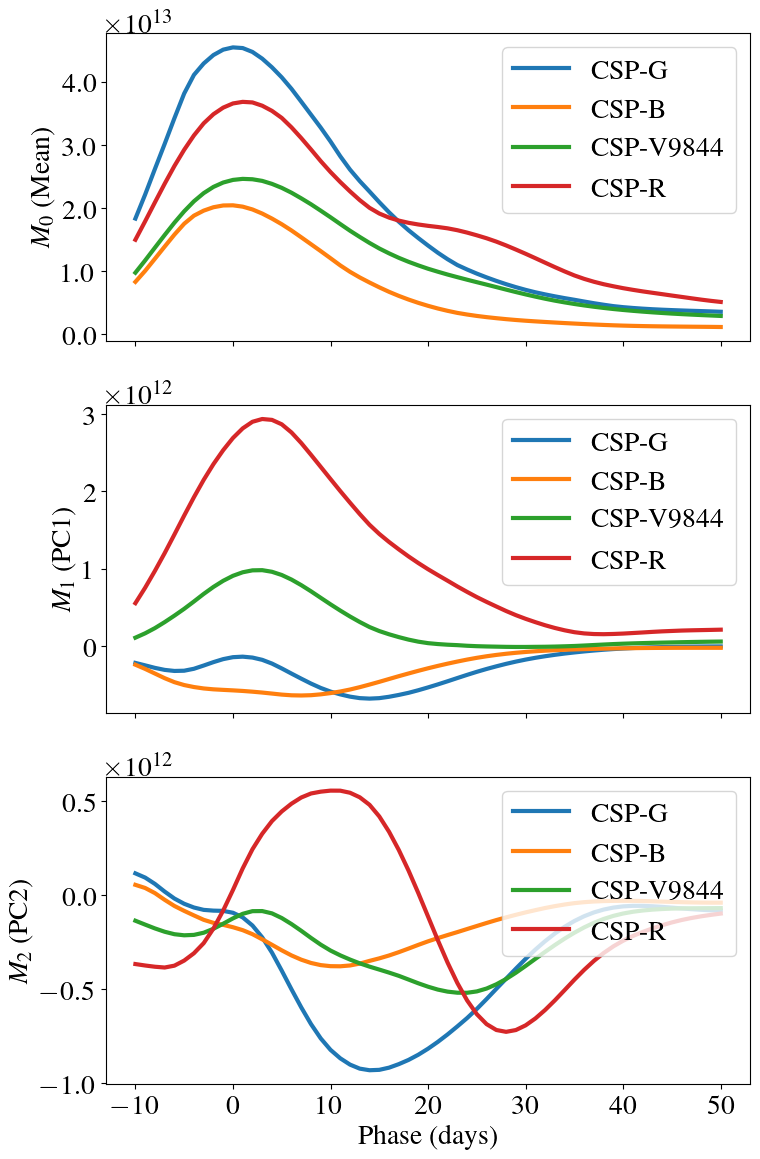

In [38]:
fig, axs = plt.subplots(3,1,figsize=(8,12),sharex=True)

colors=["C0","C1","C2","C3","C4","C5"]

axs[0].plot(X[0],M0_g,label=f"CSP-G",lw=3,color=colors[0])
axs[0].plot(X[0],M0_b,label=f"CSP-B",lw=3,color=colors[1])
axs[0].plot(X[0],M0_v,label=f"CSP-V9844",lw=3,color=colors[2])
axs[0].plot(X[0],M0_r,label=f"CSP-R",lw=3,color=colors[3])
axs[0].set_ylabel(r"$M_0$ (Mean)")
#ax1.set_title("First Principal Component")
formatter11=ScalarFormatterClass1()
formatter11.set_scientific(True)
formatter11.set_powerlimits((0,0))
axs[0].yaxis.set_major_formatter(formatter11)
axs[0].legend(loc=1)

axs[1].plot(X[0],M1_g,label=f"CSP-G",lw=3,color=colors[0])
axs[1].plot(X[0],M1_b,label=f"CSP-B",lw=3,color=colors[1])
axs[1].plot(X[0],M1_v,label=f"CSP-V9844",lw=3,color=colors[2])
axs[1].plot(X[0],M1_r,label=f"CSP-R",lw=3,color=colors[3])
axs[1].set_ylabel(r"$M_1$ (PC1)")
#ax1.set_title("First Principal Component")
formatter11=ScalarFormatterClass1()
formatter11.set_scientific(True)
formatter11.set_powerlimits((0,0))
axs[0].yaxis.set_major_formatter(formatter11)
axs[1].legend(loc=1)

axs[2].plot(X[0],M2_g,label=f"CSP-G",lw=3,color=colors[0])
axs[2].plot(X[0],M2_b,label=f"CSP-B",lw=3,color=colors[1])
axs[2].plot(X[0],M2_v,label=f"CSP-V9844",lw=3,color=colors[2])
axs[2].plot(X[0],M2_r,label=f"CSP-R",lw=3,color=colors[3])
axs[2].set_ylabel(r"$M_2$ (PC2)")
#ax1.set_title("First Principal Component")
formatter11=ScalarFormatterClass1()
formatter11.set_scientific(True)
formatter11.set_powerlimits((0,0))
axs[2].yaxis.set_major_formatter(formatter11)
axs[2].legend(loc=1)
axs[2].set_xlabel("Phase (days)")

fig.tight_layout()
plt.savefig('./pca_figures/PCA_components_broadband.png',dpi=300,facecolor='white', transparent=False,bbox_inches='tight')  

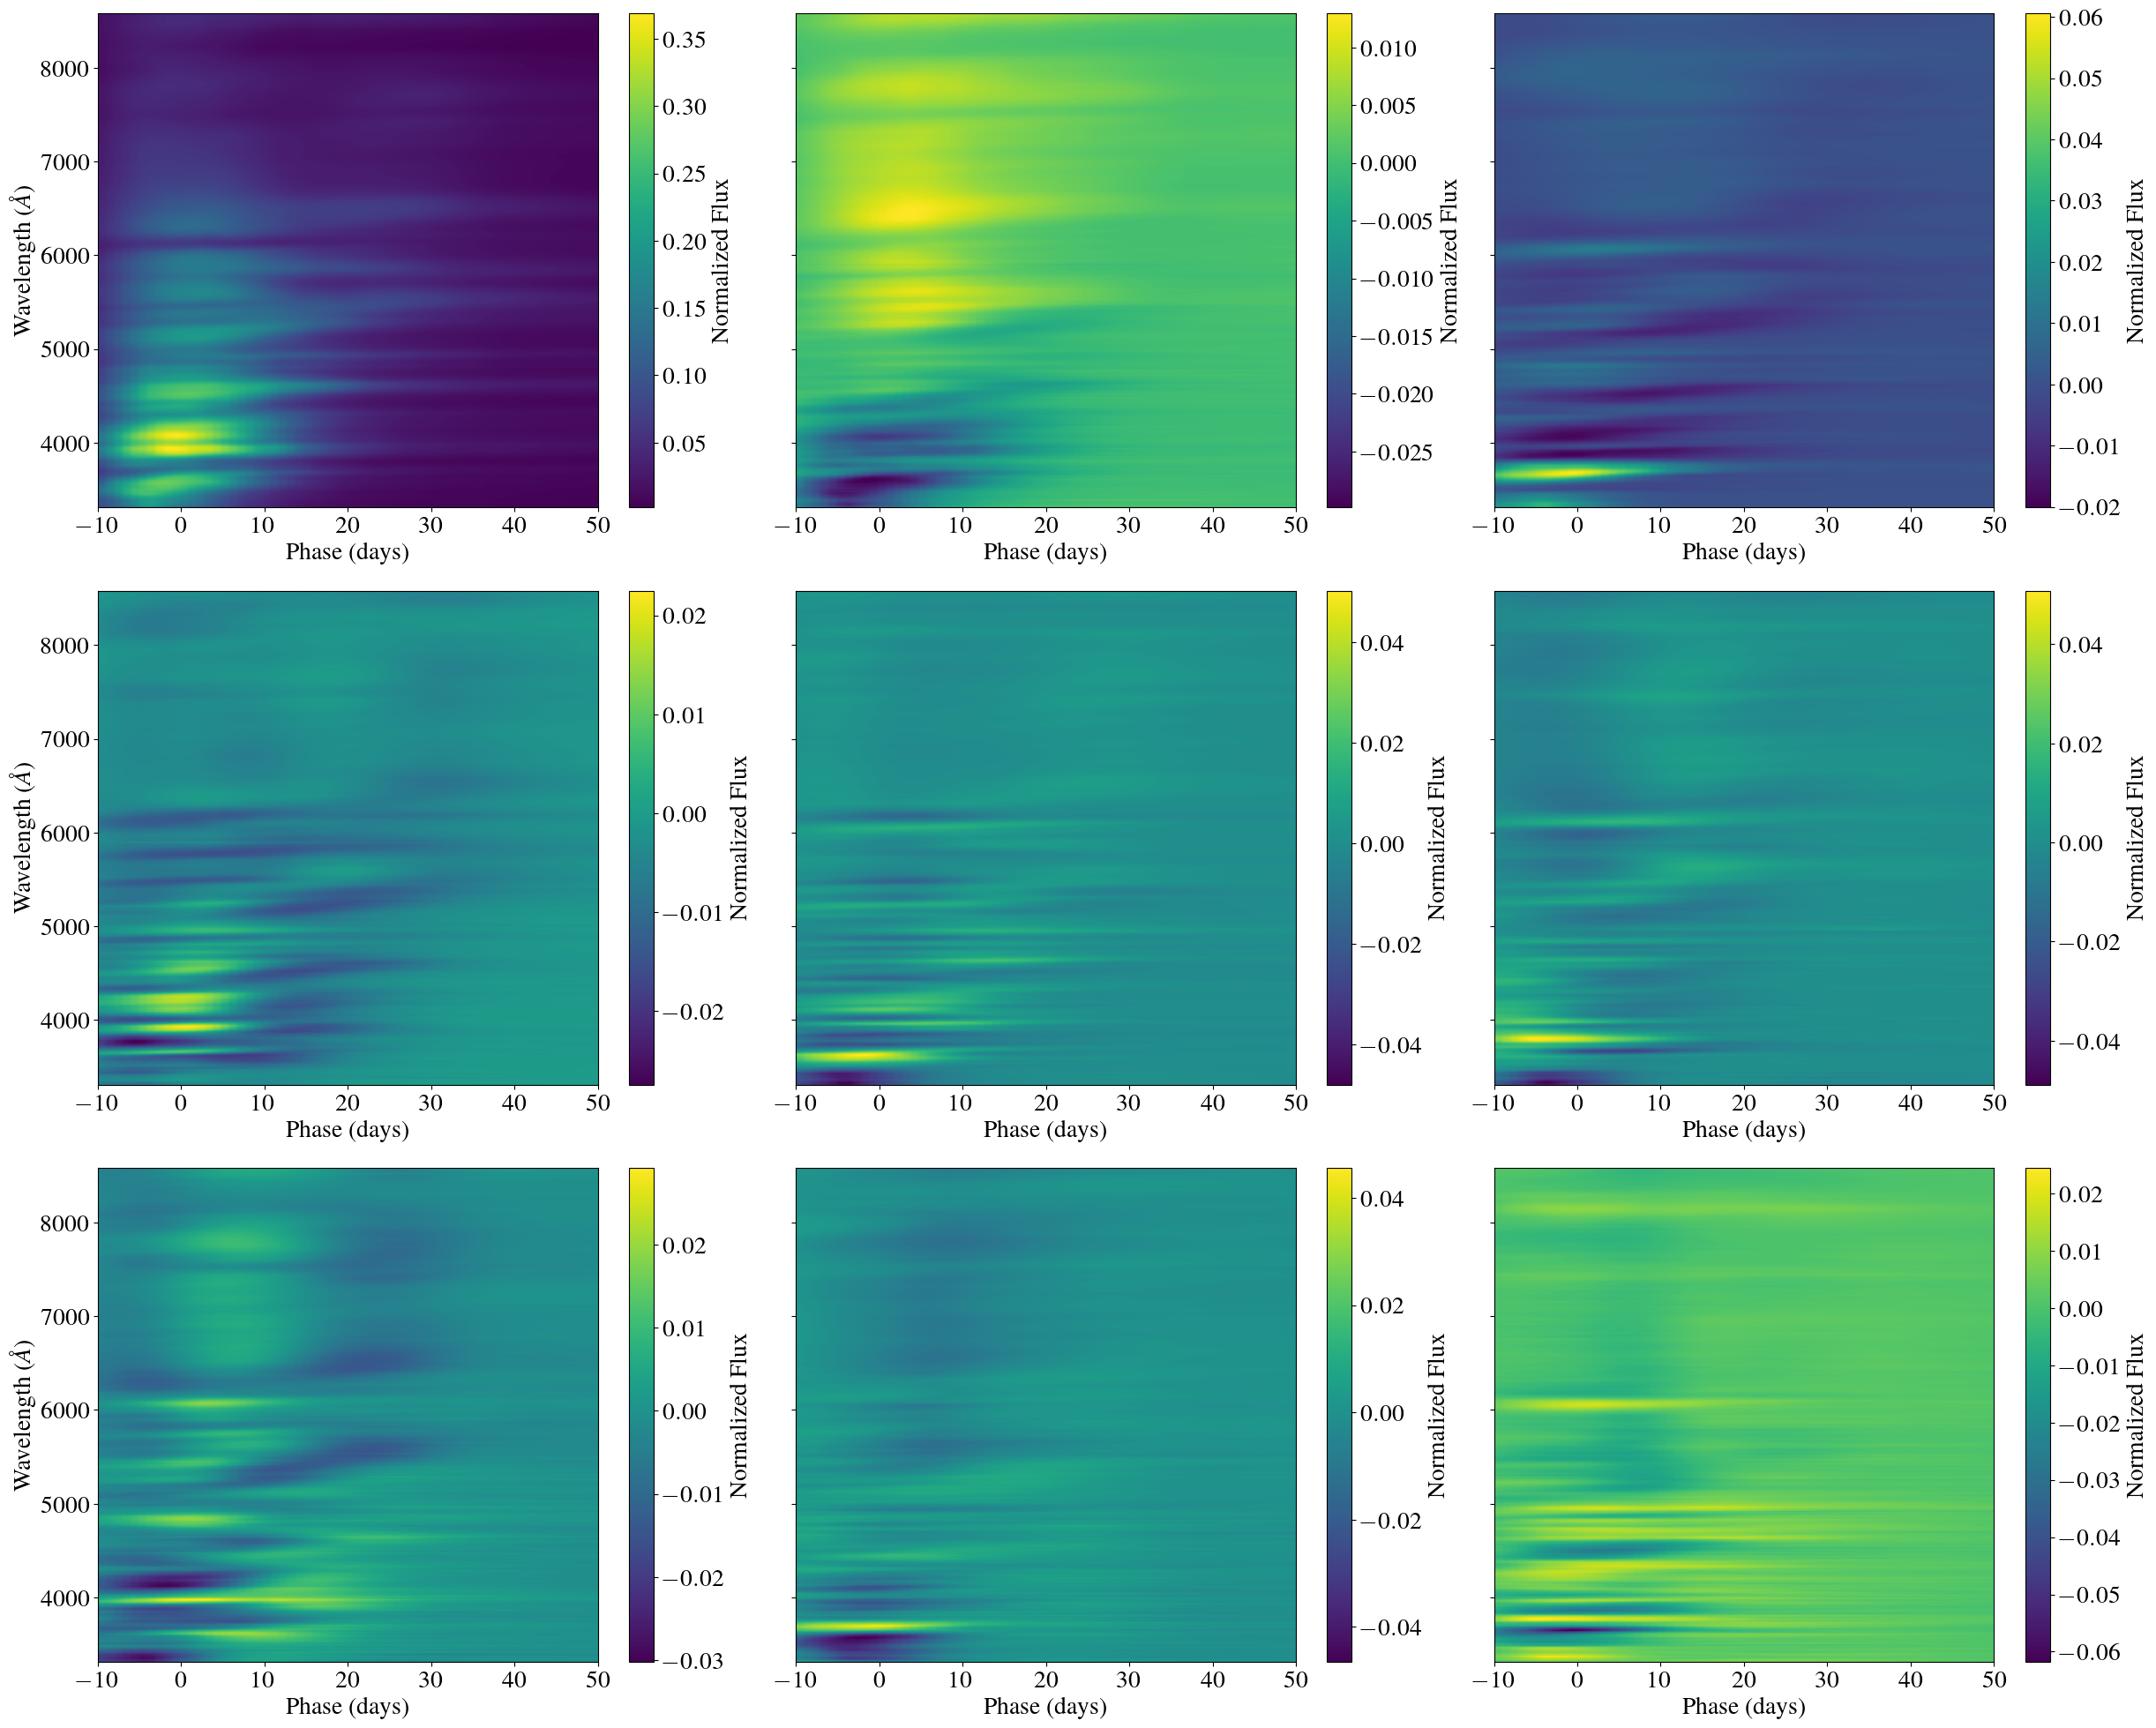

In [39]:
fig, axs = plt.subplots(3,3,figsize=(25,20),sharey=True)

im1 = axs[0,0].imshow(M0,aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M0.max(), vmin=M0.min())
axs[0,0].set_xlabel("Phase (days)")
axs[0,0].set_ylabel(r"Wavelength ($\AA$)")
fig.colorbar(im1,ax=axs[0,0],label=r"Normalized Flux")
im2 = axs[0,1].imshow(M1,aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M1.max(), vmin=M1.min())
axs[0,1].set_xlabel("Phase (days)")
fig.colorbar(im2,ax=axs[0,1],label=r"Normalized Flux")
im3 = axs[0,2].imshow(M2,aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M2.max(), vmin=M2.min())
axs[0,2].set_xlabel("Phase (days)")
fig.colorbar(im3,ax=axs[0,2],label=r"Normalized Flux")

im4 = axs[1,0].imshow(M3,aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M3.max(), vmin=M3.min())
axs[1,0].set_xlabel("Phase (days)")
axs[1,0].set_ylabel(r"Wavelength ($\AA$)")
fig.colorbar(im4,ax=axs[1,0],label=r"Normalized Flux")
im5 = axs[1,1].imshow(M4,aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M4.max(), vmin=M4.min())
axs[1,1].set_xlabel("Phase (days)")
fig.colorbar(im5,ax=axs[1,1],label=r"Normalized Flux")
im6 = axs[1,2].imshow(M5,aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M5.max(), vmin=M5.min())
axs[1,2].set_xlabel("Phase (days)")
fig.colorbar(im6,ax=axs[1,2],label=r"Normalized Flux")

im7 = axs[2,0].imshow(M6,aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M6.max(), vmin=M6.min())
axs[2,0].set_xlabel("Phase (days)")
axs[2,0].set_ylabel(r"Wavelength ($\AA$)")
fig.colorbar(im7,ax=axs[2,0],label=r"Normalized Flux")
im8 = axs[2,1].imshow(M7,aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M7.max(), vmin=M7.min())
axs[2,1].set_xlabel("Phase (days)")
fig.colorbar(im8,ax=axs[2,1],label=r"Normalized Flux")
im9 = axs[2,2].imshow(M8,aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M8.max(), vmin=M8.min())
axs[2,2].set_xlabel("Phase (days)")
fig.colorbar(im9,ax=axs[2,2],label=r"Normalized Flux")

fig.tight_layout()
plt.savefig('./pca_figures/PCA_components_2d.png',dpi=300,facecolor='white', transparent=False,bbox_inches='tight')  

## View CSP Filters

In [40]:
filters=["cspg","cspr","cspv9844"]

In [41]:
filters_label=["CSP-G","CSP-R","CSP-V9844"]

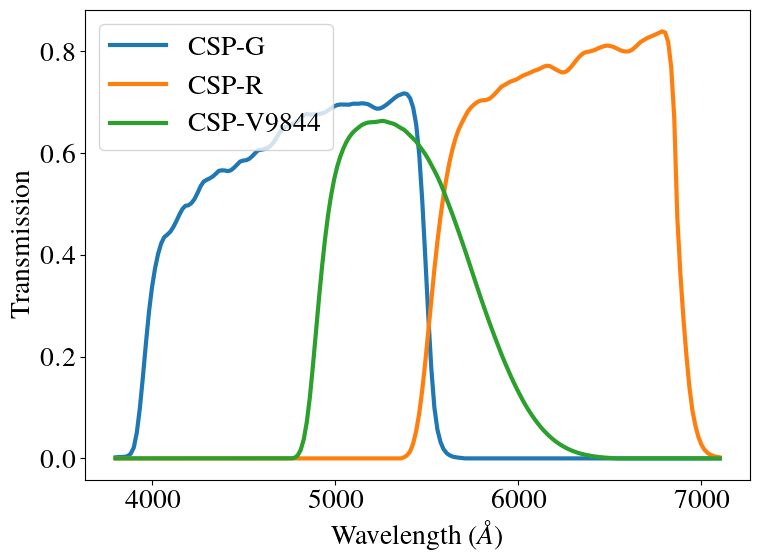

In [42]:
fig=plt.figure(figsize=(8,6))
colors=["C0","C1","C2"]
for j,f in enumerate(filters):
    plt.plot(np.linspace(3800,7100,200),sncosmo.get_bandpass(f)(np.linspace(3800,7100,200)),label=filters_label[j],lw=3,color=colors[j])
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Transmission")
plt.legend(loc=2)
fig.tight_layout()
plt.savefig('./pca_figures/validation_fits_filters.png',facecolor='white')  
# Default unit transmission in sncosmo: ratio of transmitted to incident photons.

In [43]:
csp=sncosmo.get_magsystem("csp")

## Create SNCOSMO PETS Class

In [44]:
class PETS(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12'] 
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, flux4, flux5, flux6, flux7, flux8, flux9, flux10, flux11, flux12, name='PETS', version='2024'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0.T)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1.T)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2.T)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3.T)
        self._model_flux4  = BicubicInterpolator(phase, wave, flux4.T)
        self._model_flux5  = BicubicInterpolator(phase, wave, flux5.T)
        self._model_flux6  = BicubicInterpolator(phase, wave, flux6.T)
        self._model_flux7  = BicubicInterpolator(phase, wave, flux7.T)
        self._model_flux8  = BicubicInterpolator(phase, wave, flux8.T)
        self._model_flux9  = BicubicInterpolator(phase, wave, flux9.T)
        self._model_flux10  = BicubicInterpolator(phase, wave, flux10.T)
        self._model_flux11  = BicubicInterpolator(phase, wave, flux11.T)
        self._model_flux12  = BicubicInterpolator(phase, wave, flux12.T)

        self._parameters = np.array([1,0,0,0,0,0,0,0,0,0,0,0,0])  # initial guess
        
    def _flux(self, phase, wave):
        x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12= self._parameters
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave)+  x3 * self._model_flux3(phase, wave)+  x4 * self._model_flux4(phase, wave)+  x5 * self._model_flux5(phase, wave)+  x6 * self._model_flux6(phase, wave)+  x7 * self._model_flux7(phase, wave)+  x8 * self._model_flux8(phase, wave)+  x9 * self._model_flux9(phase, wave)+  x10 * self._model_flux10(phase, wave)+  x11 * self._model_flux11(phase, wave)+  x12 * self._model_flux12(phase, wave))   
    # Para adicionar bandflux relative variance precisaríamos de superfícies com incerteza do modelo. E construir uma matriz ainda maior para incluir a covariância, onde levaríamos tbm em conta os erros de correção K

In [45]:
pets = PETS(p_grid, w_grid_reg, M0, M1, M2, M3, M4, M5, M6, M7, M8, M9, M10, M11, M12)

## Fit Synthetic Photometry

In [46]:
val_data_reshape={}
val_data_err_reshape={}
for i in range(len(val_data)):
    val_data_reshape[i]=val_data[i].reshape(X.shape)
    val_data_err_reshape[i]=val_data_err[i].reshape(X.shape)

In [47]:
chi2red_val_2=[]
chi2red_val_3=[]
chi2red_val_6=[]
chi2red_val_12=[]

In [48]:
train_data_reshape={}
train_data_err_reshape={}
for i in range(len(train_data)):
    train_data_reshape[i]=train_data[i].reshape(X.shape)
    train_data_err_reshape[i]=train_data_err[i].reshape(X.shape)

In [49]:
chi2red_train_2=[]
chi2red_train_3=[]
chi2red_train_6=[]
chi2red_train_12=[]

In [50]:
file_info=[]

In [51]:
for k in range(len(val_data_reshape)):
    print(val_names[k])
    
    fig, axs=plt.subplots(6,1,figsize=(14,14),sharex=True, gridspec_kw={'height_ratios': [5,1,5,1,5,1]})
    fig.subplots_adjust(hspace=0.4)
    colors=["C0","C1","C2","C3"]

    p_random=np.arange(-8,48,4)

    specs=[sncosmo.Spectrum(wave=Y.T[t],flux=val_data_reshape[k].T[t],fluxerr=val_data_err_reshape[k].T[t]) for t in range(len(p_grid))]  
                     
    flux_l=[]
    fluxcov_l=[]
    phase=[]
    filt=[]
    for l in range(len(p_grid)):
        if p_grid[l] in p_random:
            phase.append([p_grid[l]]*len(filters))
            flu_band,cov_band=specs[l].bandfluxcov(filters)
            flux_l.append(flu_band)
            fluxcov_l.append(cov_band)
            filt.append(filters)
        else:
            continue

    cov=block_diag(fluxcov_l[0], fluxcov_l[1], fluxcov_l[2], fluxcov_l[3], fluxcov_l[4], fluxcov_l[5], fluxcov_l[6], fluxcov_l[7], fluxcov_l[8], fluxcov_l[9], fluxcov_l[10], fluxcov_l[11], fluxcov_l[12], fluxcov_l[13])

    tab=Table({"time":np.array(phase).reshape(-1),"flux":np.array(flux_l).reshape(-1),"fluxerr":np.sqrt(cov.diagonal()),"fluxcov":cov.tolist(),"flt":np.array(filt).reshape(-1)})

    zp=[]
    zpsys=[]
    for j in tab["flt"]:
        zp.append(2.5*np.log10(csp.zpbandflux(j)))
        zpsys.append("csp")

    tab.add_column(zp,name="zp")
    tab.add_column(zpsys,name="zpsys")
    
    dust=sncosmo.F99Dust()
    model=sncosmo.Model(source=pets)
    model.set(z=0.,t0=0.) 
    
    result2, fitted_model2 = sncosmo.fit_lc(tab, model, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)
    result3, fitted_model3= sncosmo.fit_lc(tab, model, ['x0', 'x1', 'x2', 'x3'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)
    result6, fitted_model6= sncosmo.fit_lc(tab, model, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)
    result12, fitted_model12= sncosmo.fit_lc(tab, model, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)
    
    chi2red_val_2.append(np.round(result2.chisq/result2.ndof,2))
    chi2red_val_3.append(np.round(result3.chisq/result3.ndof,2))
    chi2red_val_6.append(np.round(result6.chisq/result6.ndof,2))
    chi2red_val_12.append(np.round(result12.chisq/result12.ndof,2))        

    file_df=pd.DataFrame([result2.parameters[2:],result3.parameters[2:],result6.parameters[2:],result12.parameters[2:]])
    file_df.columns=["x0","x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11","x12"]
    file_df.insert(0,"SN",[f"{val_names[k]}",f"{val_names[k]}",f"{val_names[k]}",f"{val_names[k]}"])
    file_df.insert(1,"Model",["PETS-PCA2","PETS-PCA3","PETS-PCA6","PETS-PCA12"])
    file_df.insert(15,"Type",["Validation","Validation","Validation","Validation"])
    file_df.insert(16,"Chi2red",[f"{np.round(result2.chisq/result2.ndof,2)}",f"{np.round(result3.chisq/result3.ndof,2)}",f"{np.round(result6.chisq/result6.ndof,2)}",f"{np.round(result12.chisq/result12.ndof,2)}"])
    
    file_info.append(file_df)

    l=0
    for m,f in enumerate(filters):

        dat=tab["time","flt","flux","fluxerr","zp"].to_pandas()
        dat=dat[dat["flt"]==f].reset_index(drop=True)

        zp_arr=dat[dat["flt"]==f]["zp"].values
        flux_arr=dat[dat["flt"]==f]["flux"].values

        #print(dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11))
        #print(flux_arr*10**(-0.4*zp_arr+11))        
        
        axs[l].errorbar(dat[dat["flt"]==f]["time"], dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11), yerr=dat[dat["flt"]==f]["fluxerr"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11),label="Data",color="black",ls="none",fmt='o')
        axs[l].plot(np.linspace(-10,50,100),fitted_model2.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),linewidth=4,color=colors[0],label=r"PETS-PCA2 ($\chi^2_\textnormal{red}$"+f"={np.round(result2.chisq/result2.ndof,2)})")
        axs[l].plot(np.linspace(-10,50,100),fitted_model3.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),"--",linewidth=4,color=colors[1],label=r"PETS-PCA3 ($\chi^2_\textnormal{red}$"+f"={np.round(result3.chisq/result3.ndof,2)})")
        axs[l].plot(np.linspace(-10,50,100),fitted_model6.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),"-.",linewidth=4,color=colors[2],label=r"PETS-PCA6 ($\chi^2_\textnormal{red}$"+f"={np.round(result6.chisq/result6.ndof,2)})")
        axs[l].plot(np.linspace(-10,50,100),fitted_model12.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),":",linewidth=4,color=colors[3],label=r"PETS-PCA12 ($\chi^2_\textnormal{red}$"+f"={np.round(result12.chisq/result12.ndof,2)})")
        axs[l].set_ylabel(r"Flux $ZP_{AB}=27.5$")
        formatter11=ScalarFormatterClass1()
        formatter11.set_scientific(True)
        formatter11.set_powerlimits((0,0))
        axs[l].yaxis.set_major_formatter(formatter11)
        axs[l].text(0.5,0.9,f'{filters_label[m]} filter', transform=axs[l].transAxes, fontsize=22, va='top', ha='left')
        
        pca_2=interp1d(np.linspace(-10,50,100),fitted_model2.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11))(dat[dat["flt"]==f]["time"])
        pca_3=interp1d(np.linspace(-10,50,100),fitted_model3.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11))(dat[dat["flt"]==f]["time"])
        pca_6=interp1d(np.linspace(-10,50,100),fitted_model6.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11))(dat[dat["flt"]==f]["time"])
        pca_12=interp1d(np.linspace(-10,50,100),fitted_model12.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11))(dat[dat["flt"]==f]["time"])        

        y=dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11)

        res_pca2=(pca_2-dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11))/(dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11))
        res_pca3=(pca_3-dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11))/(dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11))
        res_pca6=(pca_6-dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11))/(dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11))
        res_pca12=(pca_12-dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11))/(dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11))
        
        axs[l+1].scatter(dat[dat["flt"]==f]["time"],res_pca2,marker="s")
        axs[l+1].scatter(dat[dat["flt"]==f]["time"],res_pca3,marker="^")
        axs[l+1].scatter(dat[dat["flt"]==f]["time"],res_pca6,marker="*")
        axs[l+1].scatter(dat[dat["flt"]==f]["time"],res_pca12,marker="d")
        axs[l+1].axhline(y=0., color='black', linestyle='--')
        axs[l+1].set_ylabel("residue")

        if l ==0:
            axs[l].legend(loc=1,fontsize=15)        
            axs[l].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else: pass        
            
        if l==4:
            axs[l+1].set_xlabel("Phase (days)")

        l+=2
        
    fig.tight_layout()
    plt.savefig(f'./synthetic_photo_fits_pca/validation_set/synt_phot_fit_PCA_{val_names[k]}.pdf')#png',dpi=300,facecolor='white', transparent=False,bbox_inches='tight') 
    plt.close(fig)

Train_SN51_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN23_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN44_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN8_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN106_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN78_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN21_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN53_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN39_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN95_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN42_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN121_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN83_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN115_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN116_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN108_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


In [52]:
for k in range(len(train_data_reshape)):
    print(train_names[k])
    
    fig, axs=plt.subplots(6,1,figsize=(14,14),sharex=True, gridspec_kw={'height_ratios': [5,1,5,1,5,1]})
    fig.subplots_adjust(hspace=0.4)
    colors=["C0","C1","C2","C3"]
    
    p_random=np.arange(-8,48,4)

    specs=[sncosmo.Spectrum(wave=Y.T[t],flux=train_data_reshape[k].T[t],fluxerr=train_data_err_reshape[k].T[t]) for t in range(len(p_grid))]  
                     
    flux_l=[]
    fluxcov_l=[]
    phase=[]
    filt=[]
    for l in range(len(p_grid)):
        if p_grid[l] in p_random:
            phase.append([p_grid[l]]*len(filters))
            flu_band,cov_band=specs[l].bandfluxcov(filters)
            flux_l.append(flu_band)
            fluxcov_l.append(cov_band)
            filt.append(filters)
        else:
            continue

    cov=block_diag(fluxcov_l[0], fluxcov_l[1], fluxcov_l[2], fluxcov_l[3], fluxcov_l[4], fluxcov_l[5], fluxcov_l[6], fluxcov_l[7], fluxcov_l[8], fluxcov_l[9], fluxcov_l[10], fluxcov_l[11], fluxcov_l[12], fluxcov_l[13])

    tab=Table({"time":np.array(phase).reshape(-1),"flux":np.array(flux_l).reshape(-1),"fluxerr":np.sqrt(cov.diagonal()),"fluxcov":cov.tolist(),"flt":np.array(filt).reshape(-1)})

    zp=[]
    zpsys=[]
    for j in tab["flt"]:
        zp.append(2.5*np.log10(csp.zpbandflux(j)))
        zpsys.append("csp")

    tab.add_column(zp,name="zp")
    tab.add_column(zpsys,name="zpsys")
    
    dust = sncosmo.F99Dust()
    model = sncosmo.Model(source=pets)
    model.set(z=0.,t0=0.) 
    
    result2, fitted_model2 = sncosmo.fit_lc(tab, model, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)
    result3, fitted_model3= sncosmo.fit_lc(tab, model, ['x0', 'x1', 'x2', 'x3'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)
    result6, fitted_model6= sncosmo.fit_lc(tab, model, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)
    result12, fitted_model12= sncosmo.fit_lc(tab, model, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)

    chi2red_train_2.append(np.round(result2.chisq/result2.ndof,2))
    chi2red_train_3.append(np.round(result3.chisq/result3.ndof,2))
    chi2red_train_6.append(np.round(result6.chisq/result6.ndof,2))
    chi2red_train_12.append(np.round(result12.chisq/result12.ndof,2))        
    
    file_df=pd.DataFrame([result2.parameters[2:],result3.parameters[2:],result6.parameters[2:],result12.parameters[2:]])
    file_df.columns=["x0","x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11","x12"]
    file_df.insert(0,"SN",[f"{train_names[k]}",f"{train_names[k]}",f"{train_names[k]}",f"{train_names[k]}"])
    file_df.insert(1,"Model",["PETS-PCA2","PETS-PCA3","PETS-PCA6","PETS-PCA12"])
    file_df.insert(15,"Type",["Training","Training","Training","Training"])
    file_df.insert(16,"Chi2red",[f"{np.round(result2.chisq/result2.ndof,2)}",f"{np.round(result3.chisq/result3.ndof,2)}",f"{np.round(result6.chisq/result6.ndof,2)}",f"{np.round(result12.chisq/result12.ndof,2)}"])
    
    file_info.append(file_df)

    l=0
    for m,f in enumerate(filters):
        axs[l].errorbar(tab[tab["flt"]==f]["time"], tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11), yerr=tab[tab["flt"]==f]["fluxerr"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11),label="Data",color="black",ls="none",fmt='o')
        axs[l].plot(np.linspace(-10,50,100),fitted_model2.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11),linewidth=4,color=colors[0],label=r"PETS-PCA2 ($\chi^2_\textnormal{red}$"+f"={np.round(result2.chisq/result2.ndof,2)})")
        axs[l].plot(np.linspace(-10,50,100),fitted_model3.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11),"--",linewidth=4,color=colors[1],label=r"PETS-PCA3 ($\chi^2_\textnormal{red}$"+f"={np.round(result3.chisq/result3.ndof,2)})")
        axs[l].plot(np.linspace(-10,50,100),fitted_model6.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11),"-.",linewidth=4,color=colors[2],label=r"PETS-PCA6 ($\chi^2_\textnormal{red}$"+f"={np.round(result6.chisq/result6.ndof,2)})")
        axs[l].plot(np.linspace(-10,50,100),fitted_model12.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11),":",linewidth=4,color=colors[3],label=r"PETS-PCA12 ($\chi^2_\textnormal{red}$"+f"={np.round(result12.chisq/result12.ndof,2)})")
        axs[l].set_ylabel(r"Flux $ZP_{AB}=27.5$")
        formatter11=ScalarFormatterClass1()
        formatter11.set_scientific(True)
        formatter11.set_powerlimits((0,0))
        axs[l].yaxis.set_major_formatter(formatter11)
        axs[l].text(0.5,0.9,f'{filters_label[m]} filter', transform=axs[l].transAxes, fontsize=22, va='top', ha='left')
        
        pca_2=interp1d(np.linspace(-10,50,100),fitted_model2.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11))(tab[tab["flt"]==f]["time"])
        pca_3=interp1d(np.linspace(-10,50,100),fitted_model3.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11))(tab[tab["flt"]==f]["time"])
        pca_6=interp1d(np.linspace(-10,50,100),fitted_model6.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11))(tab[tab["flt"]==f]["time"])
        pca_12=interp1d(np.linspace(-10,50,100),fitted_model12.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11))(tab[tab["flt"]==f]["time"])

        y=tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11)
        axs[l+1].scatter(tab[tab["flt"]==f]["time"],(pca_2-tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11))/y,marker="s")
        axs[l+1].scatter(tab[tab["flt"]==f]["time"],(pca_3-tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11))/y,marker="^")
        axs[l+1].scatter(tab[tab["flt"]==f]["time"],(pca_6-tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11))/y,marker="*")
        axs[l+1].scatter(tab[tab["flt"]==f]["time"],(pca_12-tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11))/y,marker="d")
        axs[l+1].axhline(y=0., color='black', linestyle='--')
        axs[l+1].set_ylabel("residue")

        if l ==0:
            axs[l].legend(loc=1,fontsize=15)        
            axs[l].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else: pass        
            
        if l==4:
            axs[l+1].set_xlabel("Phase (days)")

        l+=2

    
    fig.tight_layout()
    plt.savefig(f'./synthetic_photo_fits_pca/training_set/synt_phot_fit_PCA_{train_names[k]}.pdf')#,dpi=300,facecolor='white', transparent=False,bbox_inches='tight') 
    plt.close(fig)

Test_SN2_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN6_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN68_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN29_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN37_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN20_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN90_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN105_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN55_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN3_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN9_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN47_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN56_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN94_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN32_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN5_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN62_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN24_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN91_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN52_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN7_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN43_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN18_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN46_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN69_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN99_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN54_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN101_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN21_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN17_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN19_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN67_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN82_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN11_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN73_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN77_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN8_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN76_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN38_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN49_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN19_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN9_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN58_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN43_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN63_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN74_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN35_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN7_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN10_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN11_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN25_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN80_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN47_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN119_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN0_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN104_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN111_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN60_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN87_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN86_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN14_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN1_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN31_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN117_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN59_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN1_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN37_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN33_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN48_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN79_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN102_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN103_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN38_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN16_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN107_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN20_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN39_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN84_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN114_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN41_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN45_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN5_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN25_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN3_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN36_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN12_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN30_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN81_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN109_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN27_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN71_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN4_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN113_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN34_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN120_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN2_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN92_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN97_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN40_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN6_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN61_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN0_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN112_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN46_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN28_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN16_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN48_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN13_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN35_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN70_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN57_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN41_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN18_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN89_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN13_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN14_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN88_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN75_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN118_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN110_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN66_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN12_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN27_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN4_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN32_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN50_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN29_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN85_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN65_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN22_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN24_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN17_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN10_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN98_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN22_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN26_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN100_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN28_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN31_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN42_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN72_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN40_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN36_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN64_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN33_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN44_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN45_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN23_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN15_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN34_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


In [53]:
file_info_concat=pd.concat(file_info,ignore_index=True)

In [54]:
file_info_concat.to_csv("./synthetic_photo_fits_pca/fit_results.dat",sep=" ",index=False)

## Analyse Fit $\chi^2_{red}$ Distributions

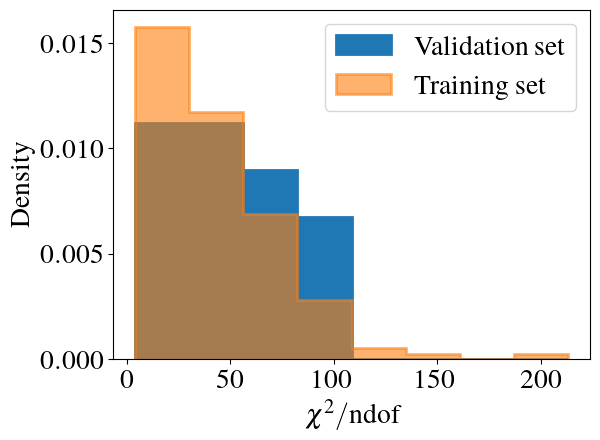

In [74]:
bins=np.histogram(np.hstack((chi2red_val_2,chi2red_train_2)), bins=8)[1]
plt.hist(chi2red_val_2,bins=bins,density=True,label="Validation set",fill=True, histtype='step',lw=2.)
plt.hist(chi2red_train_2,bins=bins,density=True,label="Training set",fill=True, histtype='step',lw=2.,alpha=0.6)
plt.xlabel(r"$\chi^2/\textnormal{ndof}$")
plt.ylabel("Density")
#plt.title("PETS-PCA2")
plt.legend()
plt.tight_layout()
plt.savefig(f'./synthetic_photo_fits_pca/chi2_pets_pca2.png',facecolor='white');

In [75]:
ks_2samp(chi2red_val_2,chi2red_train_2)

KstestResult(statistic=0.19294117647058823, pvalue=0.5526175295207618, statistic_location=65.57, statistic_sign=-1)

In [76]:
print("PETS-PCA2 - Fraction of chi2red<30:")
print(f"Validation set: {len([i for i in chi2red_val_2 if i<30])/len(chi2red_val_2)}")
print(f"Training set: {len([i for i in chi2red_train_2 if i<30])/len(chi2red_train_2)}")
print("\n")
print("PETS-PCA2 - Fraction of chi2red<100:")
print(f"Validation set: {len([i for i in chi2red_val_2 if i<100])/len(chi2red_val_2)}")
print(f"Training set: {len([i for i in chi2red_train_2 if i<100])/len(chi2red_train_2)}")
print("\n")
print("PETS-PCA2 - Fraction of chi2red<200:")
print(f"Validation set: {len([i for i in chi2red_val_2 if i<200])/len(chi2red_val_2)}")
print(f"Training set: {len([i for i in chi2red_train_2 if i<200])/len(chi2red_train_2)}")

PETS-PCA2 - Fraction of chi2red<30:
Validation set: 0.29411764705882354
Training set: 0.41333333333333333


PETS-PCA2 - Fraction of chi2red<100:
Validation set: 0.9411764705882353
Training set: 0.9533333333333334


PETS-PCA2 - Fraction of chi2red<200:
Validation set: 1.0
Training set: 0.9933333333333333


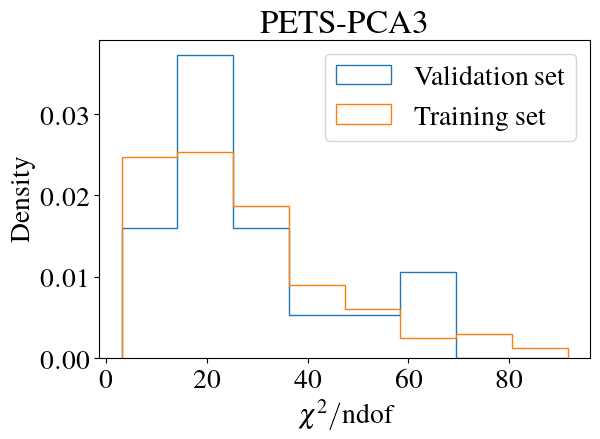

In [77]:
bins=np.histogram(np.hstack((chi2red_val_3,chi2red_train_3)), bins=8)[1]
plt.hist(chi2red_val_3,bins=bins,density=True,label="Validation set",fill=False, histtype='step')
plt.hist(chi2red_train_3,bins=bins,density=True,label="Training set",fill=False, histtype='step')
plt.xlabel(r"$\chi^2/\textnormal{ndof}$")
plt.ylabel("Density")
plt.title("PETS-PCA3")
plt.legend()
plt.tight_layout()
plt.savefig(f'./synthetic_photo_fits_pca/chi2_pets_pca3.png',facecolor='white');

In [78]:
ks_2samp(chi2red_val_3,chi2red_train_3)

KstestResult(statistic=0.1980392156862745, pvalue=0.5199624532151588, statistic_location=20.72, statistic_sign=-1)

In [79]:
print("PETS-PCA3 - Fraction of chi2red<30:")
print(f"Validation set: {len([i for i in chi2red_val_3 if i<30])/len(chi2red_val_3)}")
print(f"Training set: {len([i for i in chi2red_train_3 if i<30])/len(chi2red_train_3)}")
print("\n")
print("PETS-PCA3 - Fraction of chi2red<100:")
print(f"Validation set: {len([i for i in chi2red_val_3 if i<100])/len(chi2red_val_3)}")
print(f"Training set: {len([i for i in chi2red_train_3 if i<100])/len(chi2red_train_3)}")
print("\n")
print("PETS-PCA3 - Fraction of chi2red<200:")
print(f"Validation set: {len([i for i in chi2red_val_3 if i<200])/len(chi2red_val_3)}")
print(f"Training set: {len([i for i in chi2red_train_3 if i<200])/len(chi2red_train_3)}")

PETS-PCA3 - Fraction of chi2red<30:
Validation set: 0.7058823529411765
Training set: 0.66


PETS-PCA3 - Fraction of chi2red<100:
Validation set: 1.0
Training set: 1.0


PETS-PCA3 - Fraction of chi2red<200:
Validation set: 1.0
Training set: 1.0


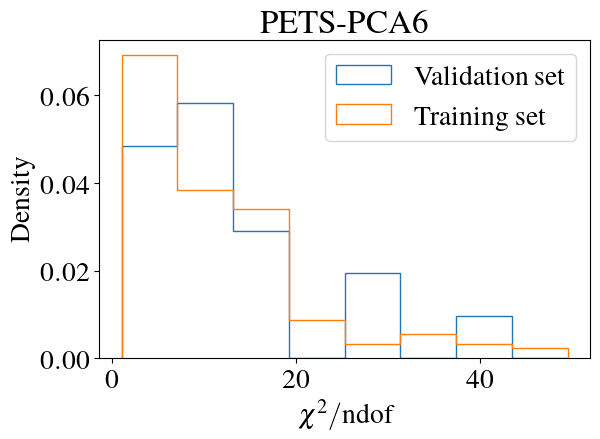

In [80]:
bins=np.histogram(np.hstack((chi2red_val_6,chi2red_train_6)), bins=8)[1]
plt.hist(chi2red_val_6,bins=bins,density=True,label="Validation set",fill=False, histtype='step')
plt.hist(chi2red_train_6,bins=bins,density=True,label="Training set",fill=False, histtype='step')
plt.xlabel(r"$\chi^2/\textnormal{ndof}$")
plt.ylabel("Density")
plt.title("PETS-PCA6")
plt.legend()
plt.tight_layout()
plt.savefig(f'./synthetic_photo_fits_pca/chi2_pets_pca6.png',facecolor='white');

In [81]:
ks_2samp(chi2red_val_6,chi2red_train_6)

KstestResult(statistic=0.1807843137254902, pvalue=0.6313448994102117, statistic_location=3.72, statistic_sign=1)

In [82]:
print("PETS-PCA6 - Fraction of chi2red<20:")
print(f"Validation set: {len([i for i in chi2red_val_6 if i<20])/len(chi2red_val_6)}")
print(f"Training set: {len([i for i in chi2red_train_6 if i<20])/len(chi2red_train_6)}")
print("\n")
print("PETS-PCA6 - Fraction of chi2red<40:")
print(f"Validation set: {len([i for i in chi2red_val_6 if i<40])/len(chi2red_val_6)}")
print(f"Training set: {len([i for i in chi2red_train_6 if i<40])/len(chi2red_train_6)}")
print("\n")
print("PETS-PCA6 - Fraction of chi2red<60:")
print(f"Validation set: {len([i for i in chi2red_val_6 if i<60])/len(chi2red_val_6)}")
print(f"Training set: {len([i for i in chi2red_train_6 if i<60])/len(chi2red_train_6)}")

PETS-PCA6 - Fraction of chi2red<20:
Validation set: 0.8235294117647058
Training set: 0.8666666666666667


PETS-PCA6 - Fraction of chi2red<40:
Validation set: 1.0
Training set: 0.9866666666666667


PETS-PCA6 - Fraction of chi2red<60:
Validation set: 1.0
Training set: 1.0


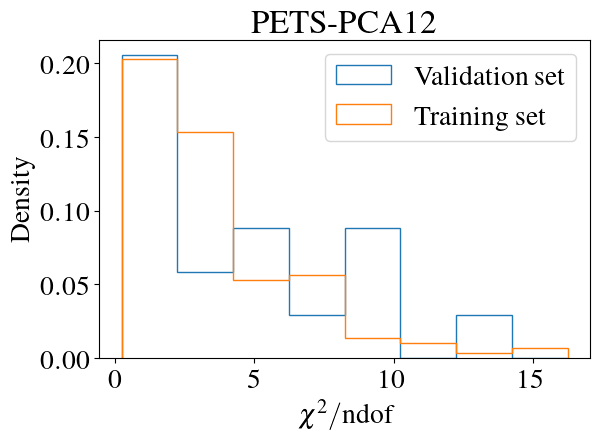

In [83]:
bins=np.histogram(np.hstack((chi2red_val_12,chi2red_train_12)), bins=8)[1]
plt.hist(chi2red_val_12,bins=bins,density=True,label="Validation set",fill=False, histtype='step')
plt.hist(chi2red_train_12,bins=bins,density=True,label="Training set",fill=False, histtype='step')
plt.xlabel(r"$\chi^2/\textnormal{ndof}$")
plt.ylabel("Density")
plt.title("PETS-PCA12")
plt.legend()
plt.tight_layout()
plt.savefig(f'./synthetic_photo_fits_pca/chi2_pets_pca12.png',facecolor='white');

In [84]:
ks_2samp(chi2red_val_12,chi2red_train_12)

KstestResult(statistic=0.24274509803921568, pvalue=0.27794571984406546, statistic_location=4.05, statistic_sign=-1)

In [85]:
print("PETS-PCA12 - Fraction of chi2red<3:")
print(f"Validation set: {len([i for i in chi2red_val_12 if i<3])/len(chi2red_val_12)}")
print(f"Training set: {len([i for i in chi2red_train_12 if i<3])/len(chi2red_train_12)}")
print("\n")
print("PETS-PCA12 - Fraction of chi2red<5:")
print(f"Validation set: {len([i for i in chi2red_val_12 if i<5])/len(chi2red_val_12)}")
print(f"Training set: {len([i for i in chi2red_train_12 if i<5])/len(chi2red_train_12)}")
print("\n")
print("PETS-PCA12 - Fraction of chi2red<10:")
print(f"Validation set: {len([i for i in chi2red_val_12 if i<10])/len(chi2red_val_12)}")
print(f"Training set: {len([i for i in chi2red_train_12 if i<10])/len(chi2red_train_12)}")

PETS-PCA12 - Fraction of chi2red<3:
Validation set: 0.47058823529411764
Training set: 0.5533333333333333


PETS-PCA12 - Fraction of chi2red<5:
Validation set: 0.5882352941176471
Training set: 0.7533333333333333


PETS-PCA12 - Fraction of chi2red<10:
Validation set: 0.9411764705882353
Training set: 0.96


## Analyse Fit Parameters Distributions

In [86]:
PCA2_VAL=file_info_concat[(file_info_concat["Model"]=="PETS-PCA2") & (file_info_concat["Type"]=="Validation")]
PCA2_TRAIN=file_info_concat[(file_info_concat["Model"]=="PETS-PCA2") & (file_info_concat["Type"]=="Training")]

In [87]:
x1_val_PCA2=np.percentile(PCA2_VAL[abs(PCA2_VAL["x1"])<10.]["x1"],[5,50,95])
x2_val_PCA2=np.percentile(PCA2_VAL[abs(PCA2_VAL["x2"])<10.]["x2"],[5,50,95])

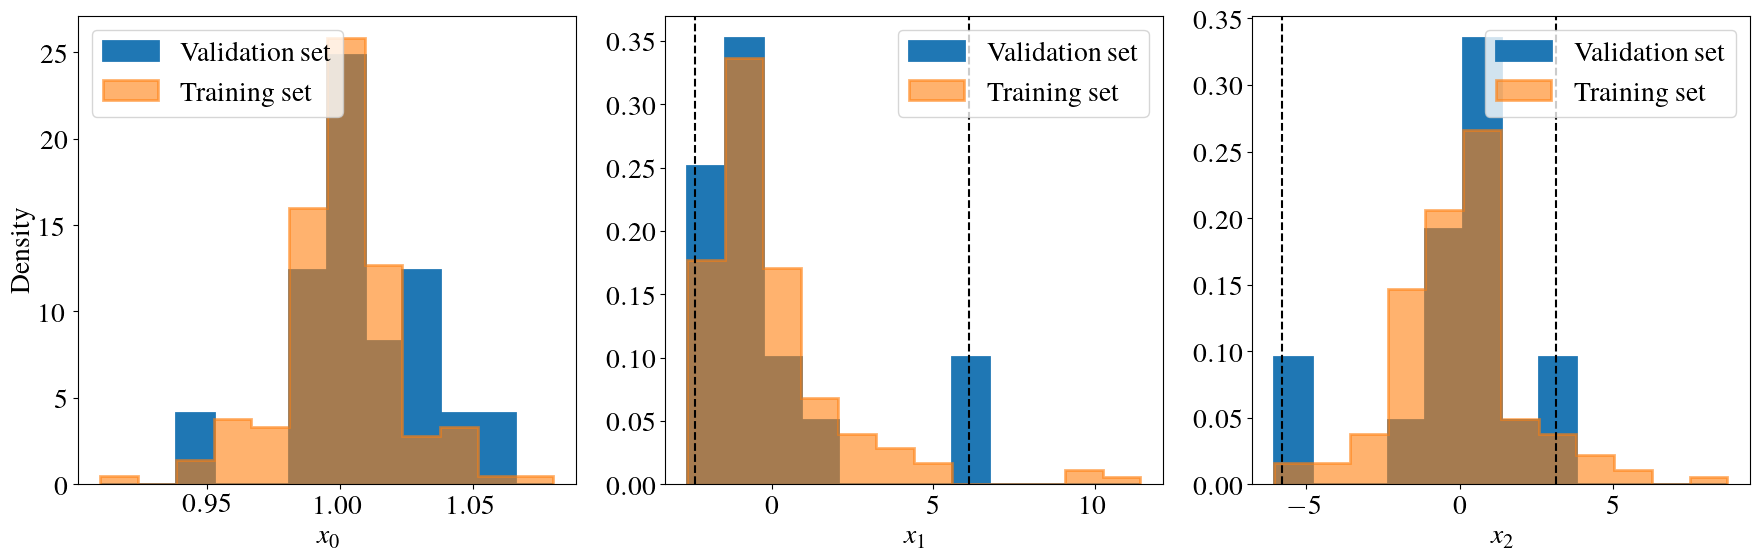

In [88]:
fig, axs = plt.subplots(1,3,figsize=(18,6))

bins0=np.histogram(np.hstack((PCA2_VAL["x0"].values,PCA2_TRAIN["x0"].values)), bins=12)[1]
axs[0].hist(PCA2_VAL["x0"].values,bins=bins0,density=True,label="Validation set",fill=True, histtype='step',lw=2.)
axs[0].hist(PCA2_TRAIN["x0"].values,bins=bins0,density=True,label="Training set",fill=True, histtype='step',lw=2.,alpha=0.6)
axs[0].set_xlabel(r"$x_0$")
axs[0].set_ylabel("Density")
axs[0].legend()

bins1=np.histogram(np.hstack((PCA2_VAL["x1"].values,PCA2_TRAIN["x1"].values)), bins=12)[1]
axs[1].hist(PCA2_VAL["x1"].values,bins=bins1,density=True,label="Validation set",fill=True, histtype='step',lw=2.)
axs[1].hist(PCA2_TRAIN["x1"].values,bins=bins1,density=True,label="Training set",fill=True, histtype='step',lw=2.,alpha=0.6)
axs[1].set_xlabel(r"$x_1$")
axs[1].axvline(x1_val_PCA2[0],ls='--',c="black")
axs[1].axvline(x1_val_PCA2[2],ls='--',c="black")
axs[1].legend()

bins2=np.histogram(np.hstack((PCA2_VAL["x2"].values,PCA2_TRAIN["x2"].values)), bins=12)[1]
axs[2].hist(PCA2_VAL["x2"].values,bins=bins2,density=True,label="Validation set",fill=True, histtype='step',lw=2.)
axs[2].hist(PCA2_TRAIN["x2"].values,bins=bins2,density=True,label="Training set",fill=True, histtype='step',lw=2.,alpha=0.6)
axs[2].set_xlabel(r"$x_2$")
axs[2].axvline(x2_val_PCA2[0],ls='--',c="black")
axs[2].axvline(x2_val_PCA2[2],ls='--',c="black")
axs[2].legend()

#plt.suptitle("PETS-PCA2")
fig.tight_layout()
plt.savefig(f'./synthetic_photo_fits_pca/par_dist_pets_pca2.png',facecolor='white');

In [89]:
ks_2samp(PCA2_VAL["x0"].values,PCA2_TRAIN["x0"].values)

KstestResult(statistic=0.22745098039215686, pvalue=0.34952717172051506, statistic_location=1.0335744052550604, statistic_sign=-1)

In [90]:
ks_2samp(PCA2_VAL["x1"].values,PCA2_TRAIN["x1"].values)

KstestResult(statistic=0.2372549019607843, pvalue=0.3023190047998163, statistic_location=-1.3185328294848593, statistic_sign=1)

In [91]:
ks_2samp(PCA2_VAL["x2"].values,PCA2_TRAIN["x2"].values)

KstestResult(statistic=0.17254901960784313, pvalue=0.6881223643990279, statistic_location=-0.1858419087280269, statistic_sign=-1)

In [92]:
PCA3_VAL=file_info_concat[(file_info_concat["Model"]=="PETS-PCA3") & (file_info_concat["Type"]=="Validation")]
PCA3_TRAIN=file_info_concat[(file_info_concat["Model"]=="PETS-PCA3") & (file_info_concat["Type"]=="Training")]

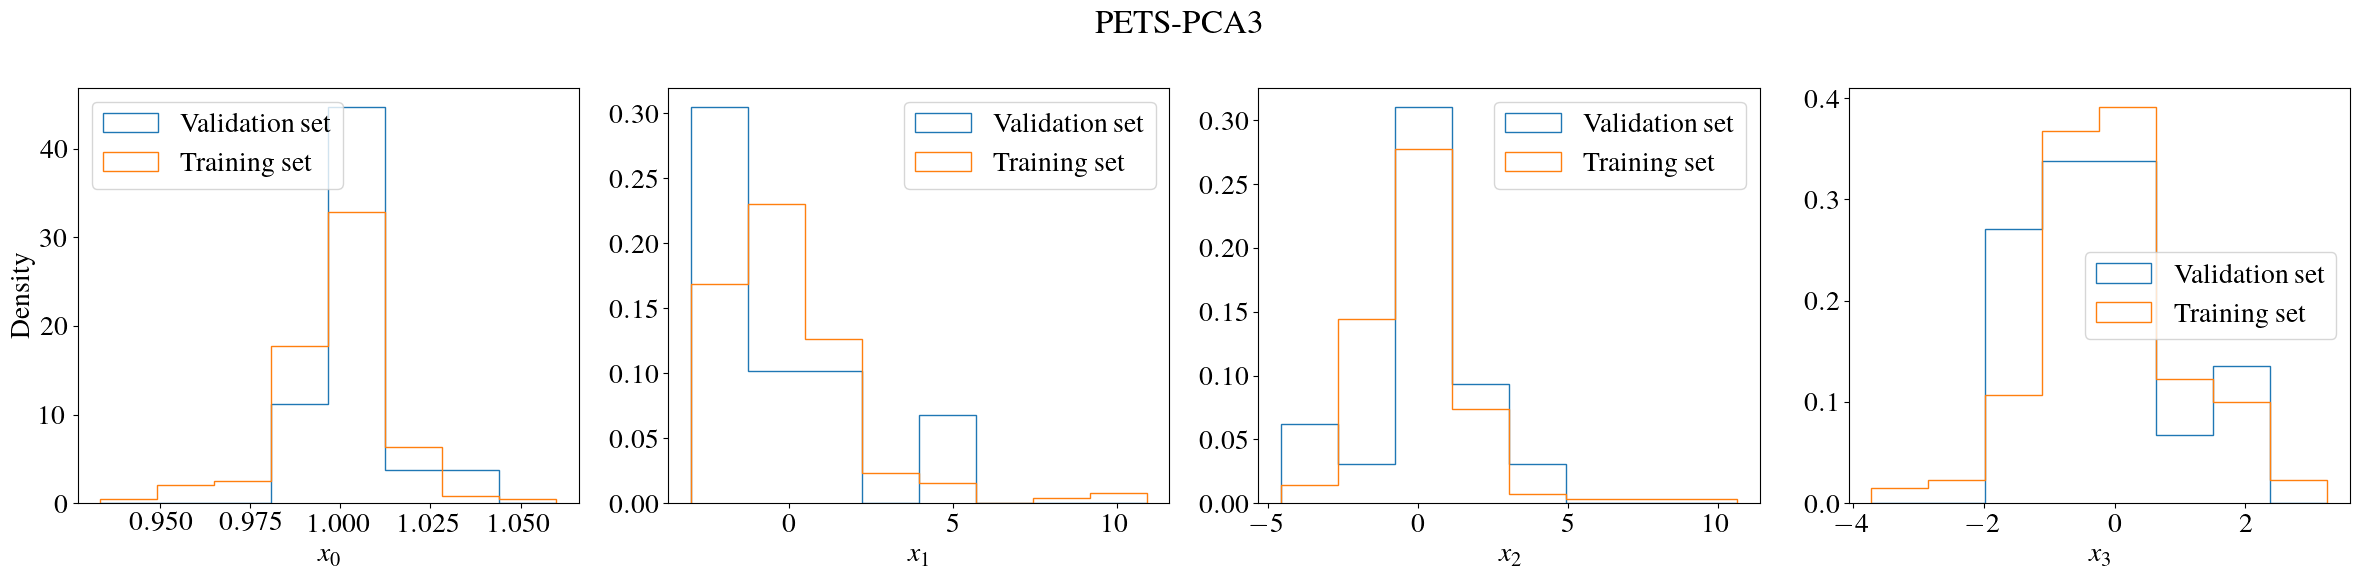

In [93]:
fig, axs = plt.subplots(1,4,figsize=(24,6))

bins0=np.histogram(np.hstack((PCA3_VAL["x0"].values,PCA3_TRAIN["x0"].values)), bins=8)[1]
axs[0].hist(PCA3_VAL["x0"].values,bins=bins0,density=True,label="Validation set",fill=False, histtype='step')
axs[0].hist(PCA3_TRAIN["x0"].values,bins=bins0,density=True,label="Training set",fill=False, histtype='step')
axs[0].set_xlabel(r"$x_0$")
axs[0].set_ylabel("Density")
axs[0].legend()

bins1=np.histogram(np.hstack((PCA3_VAL["x1"].values,PCA3_TRAIN["x1"].values)), bins=8)[1]
axs[1].hist(PCA3_VAL["x1"].values,bins=bins1,density=True,label="Validation set",fill=False, histtype='step')
axs[1].hist(PCA3_TRAIN["x1"].values,bins=bins1,density=True,label="Training set",fill=False, histtype='step')
axs[1].set_xlabel(r"$x_1$")
axs[1].legend()

bins2=np.histogram(np.hstack((PCA3_VAL["x2"].values,PCA3_TRAIN["x2"].values)), bins=8)[1]
axs[2].hist(PCA3_VAL["x2"].values,bins=bins2,density=True,label="Validation set",fill=False, histtype='step')
axs[2].hist(PCA3_TRAIN["x2"].values,bins=bins2,density=True,label="Training set",fill=False, histtype='step')
axs[2].set_xlabel(r"$x_2$")
axs[2].legend()

bins3=np.histogram(np.hstack((PCA3_VAL["x3"].values,PCA3_TRAIN["x3"].values)), bins=8)[1]
axs[3].hist(PCA3_VAL["x3"].values,bins=bins3,density=True,label="Validation set",fill=False, histtype='step')
axs[3].hist(PCA3_TRAIN["x3"].values,bins=bins3,density=True,label="Training set",fill=False, histtype='step')
axs[3].set_xlabel(r"$x_3$")
axs[3].legend()

plt.suptitle("PETS-PCA3")
fig.tight_layout()
plt.savefig(f'./synthetic_photo_fits_pca/par_dist_pets_pca3.png',facecolor='white');

In [94]:
ks_2samp(PCA3_VAL["x0"].values,PCA3_TRAIN["x0"].values)

KstestResult(statistic=0.2968627450980392, pvalue=0.10846931129114204, statistic_location=1.0001324830298528, statistic_sign=-1)

In [95]:
ks_2samp(PCA3_VAL["x1"].values,PCA3_TRAIN["x1"].values)

KstestResult(statistic=0.29058823529411765, pvalue=0.12152326056190384, statistic_location=-1.6790406437727166, statistic_sign=1)

In [96]:
ks_2samp(PCA3_VAL["x2"].values,PCA3_TRAIN["x2"].values)

KstestResult(statistic=0.17607843137254903, pvalue=0.660681331097893, statistic_location=0.3393704237111566, statistic_sign=-1)

In [97]:
ks_2samp(PCA3_VAL["x3"].values,PCA3_TRAIN["x3"].values)

KstestResult(statistic=0.18509803921568627, pvalue=0.6028880290461819, statistic_location=-0.7119364763126251, statistic_sign=1)

In [98]:
PCA6_VAL=file_info_concat[(file_info_concat["Model"]=="PETS-PCA6") & (file_info_concat["Type"]=="Validation")]
PCA6_TRAIN=file_info_concat[(file_info_concat["Model"]=="PETS-PCA6") & (file_info_concat["Type"]=="Training")]

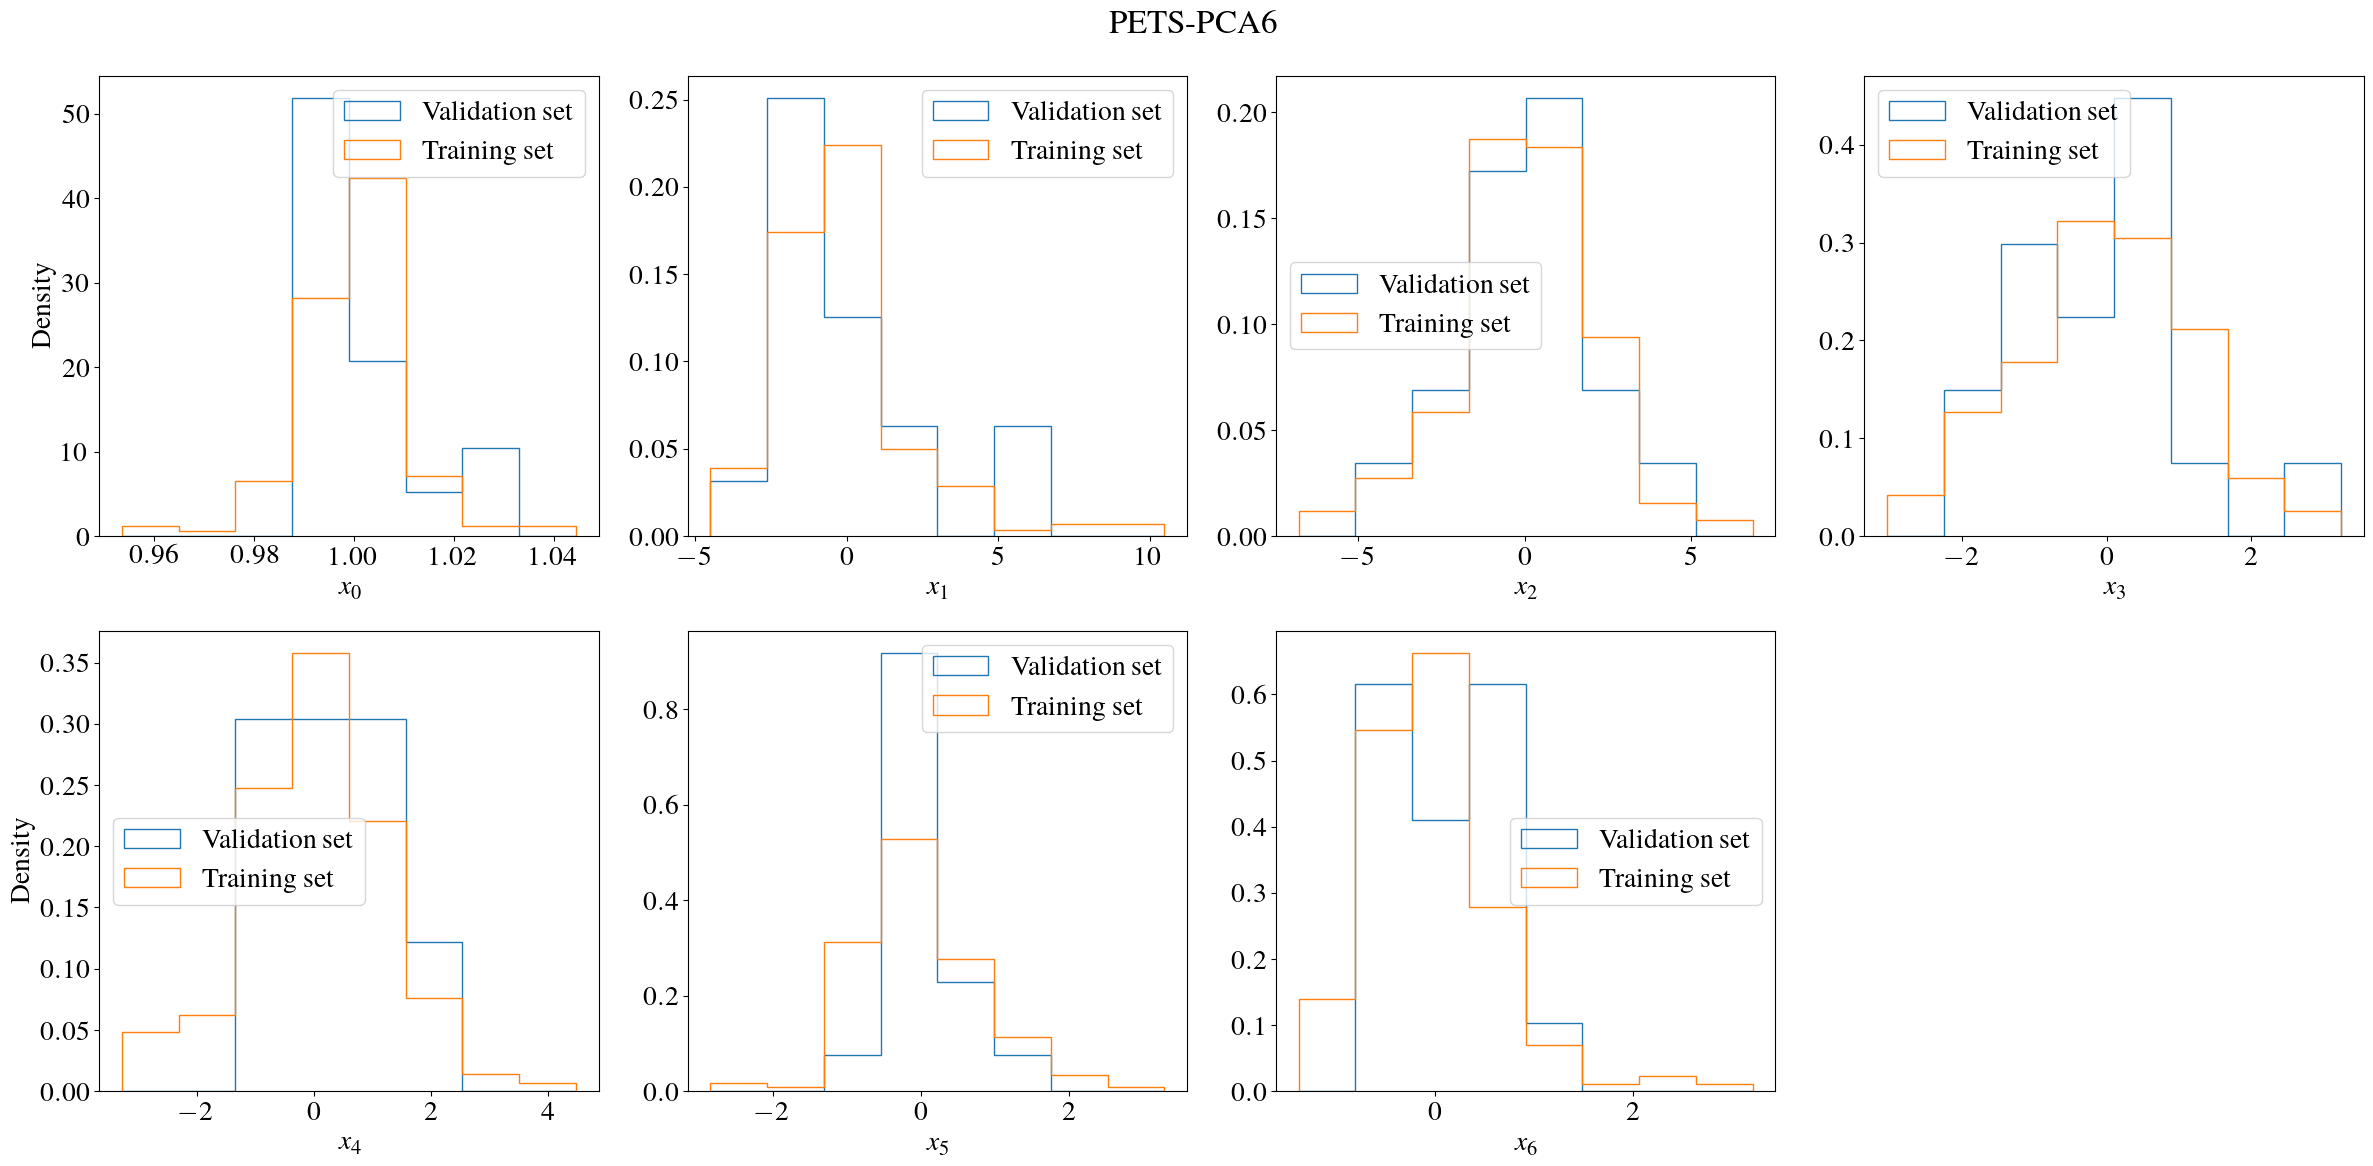

In [99]:
fig, axs = plt.subplots(2,4,figsize=(24,12))

bins0=np.histogram(np.hstack((PCA6_VAL["x0"].values,PCA6_TRAIN["x0"].values)), bins=8)[1]
axs[0,0].hist(PCA6_VAL["x0"].values,bins=bins0,density=True,label="Validation set",fill=False, histtype='step')
axs[0,0].hist(PCA6_TRAIN["x0"].values,bins=bins0,density=True,label="Training set",fill=False, histtype='step')
axs[0,0].set_xlabel(r"$x_0$")
axs[0,0].set_ylabel("Density")
axs[0,0].legend()

bins1=np.histogram(np.hstack((PCA6_VAL["x1"].values,PCA6_TRAIN["x1"].values)), bins=8)[1]
axs[0,1].hist(PCA6_VAL["x1"].values,bins=bins1,density=True,label="Validation set",fill=False, histtype='step')
axs[0,1].hist(PCA6_TRAIN["x1"].values,bins=bins1,density=True,label="Training set",fill=False, histtype='step')
axs[0,1].set_xlabel(r"$x_1$")
axs[0,1].legend()

bins2=np.histogram(np.hstack((PCA6_VAL["x2"].values,PCA6_TRAIN["x2"].values)), bins=8)[1]
axs[0,2].hist(PCA6_VAL["x2"].values,bins=bins2,density=True,label="Validation set",fill=False, histtype='step')
axs[0,2].hist(PCA6_TRAIN["x2"].values,bins=bins2,density=True,label="Training set",fill=False, histtype='step')
axs[0,2].set_xlabel(r"$x_2$")
axs[0,2].legend()

bins3=np.histogram(np.hstack((PCA6_VAL["x3"].values,PCA6_TRAIN["x3"].values)), bins=8)[1]
axs[0,3].hist(PCA6_VAL["x3"].values,bins=bins3,density=True,label="Validation set",fill=False, histtype='step')
axs[0,3].hist(PCA6_TRAIN["x3"].values,bins=bins3,density=True,label="Training set",fill=False, histtype='step')
axs[0,3].set_xlabel(r"$x_3$")
axs[0,3].legend()

bins4=np.histogram(np.hstack((PCA6_VAL["x4"].values,PCA6_TRAIN["x4"].values)), bins=8)[1]
axs[1,0].hist(PCA6_VAL["x4"].values,bins=bins4,density=True,label="Validation set",fill=False, histtype='step')
axs[1,0].hist(PCA6_TRAIN["x4"].values,bins=bins4,density=True,label="Training set",fill=False, histtype='step')
axs[1,0].set_ylabel("Density")
axs[1,0].set_xlabel(r"$x_4$")
axs[1,0].legend()

bins5=np.histogram(np.hstack((PCA6_VAL["x5"].values,PCA6_TRAIN["x5"].values)), bins=8)[1]
axs[1,1].hist(PCA6_VAL["x5"].values,bins=bins5,density=True,label="Validation set",fill=False, histtype='step')
axs[1,1].hist(PCA6_TRAIN["x5"].values,bins=bins5,density=True,label="Training set",fill=False, histtype='step')
axs[1,1].set_xlabel(r"$x_5$")
axs[1,1].legend()

bins6=np.histogram(np.hstack((PCA6_VAL["x6"].values,PCA6_TRAIN["x6"].values)), bins=8)[1]
axs[1,2].hist(PCA6_VAL["x6"].values,bins=bins6,density=True,label="Validation set",fill=False, histtype='step')
axs[1,2].hist(PCA6_TRAIN["x6"].values,bins=bins6,density=True,label="Training set",fill=False, histtype='step')
axs[1,2].set_xlabel(r"$x_6$")
axs[1,2].legend()

axs[1,3].remove()
plt.suptitle("PETS-PCA6")

fig.tight_layout()
plt.savefig(f'./synthetic_photo_fits_pca/par_dist_pets_pca6.png',facecolor='white');

In [100]:
PCA12_VAL=file_info_concat[(file_info_concat["Model"]=="PETS-PCA12") & (file_info_concat["Type"]=="Validation")]
PCA12_TRAIN=file_info_concat[(file_info_concat["Model"]=="PETS-PCA12") & (file_info_concat["Type"]=="Training")]

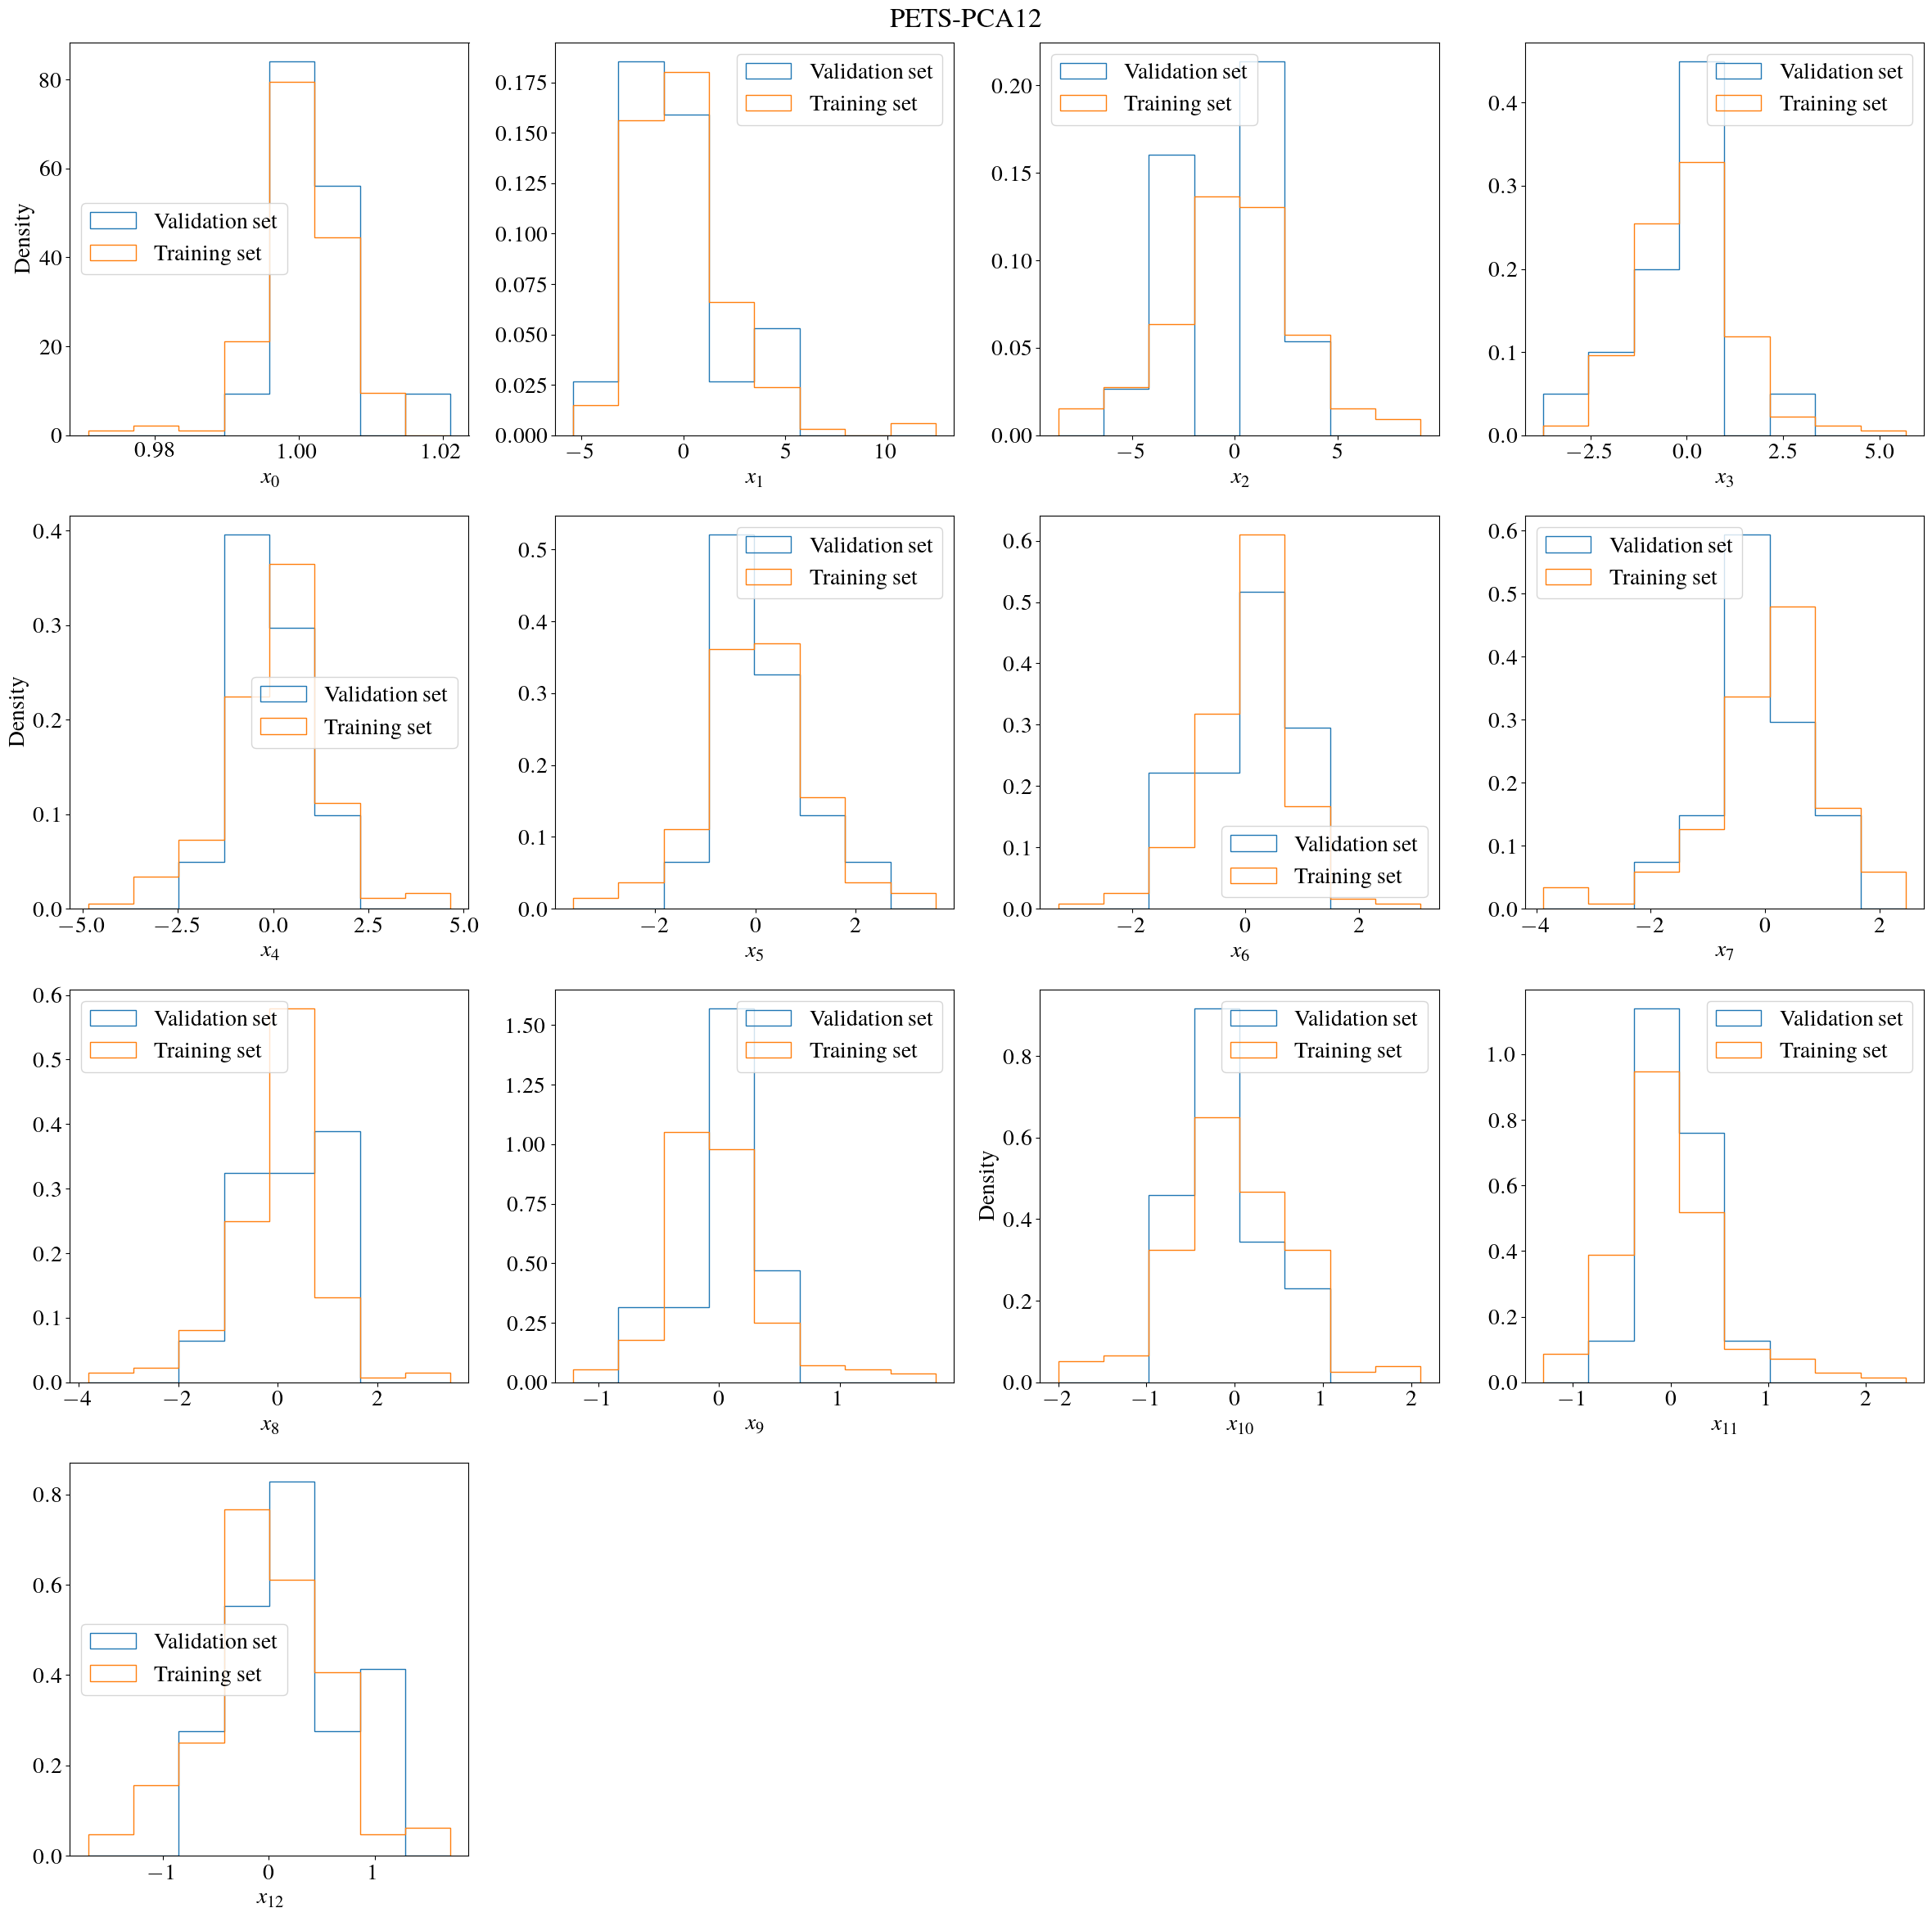

In [101]:
fig, axs = plt.subplots(4,4,figsize=(24,24))

bins0=np.histogram(np.hstack((PCA12_VAL["x0"].values,PCA12_TRAIN["x0"].values)), bins=8)[1]
axs[0,0].hist(PCA12_VAL["x0"].values,bins=bins0,density=True,label="Validation set",fill=False, histtype='step')
axs[0,0].hist(PCA12_TRAIN["x0"].values,bins=bins0,density=True,label="Training set",fill=False, histtype='step')
axs[0,0].set_xlabel(r"$x_0$")
axs[0,0].set_ylabel("Density")
axs[0,0].legend()

bins1=np.histogram(np.hstack((PCA12_VAL["x1"].values,PCA12_TRAIN["x1"].values)), bins=8)[1]
axs[0,1].hist(PCA12_VAL["x1"].values,bins=bins1,density=True,label="Validation set",fill=False, histtype='step')
axs[0,1].hist(PCA12_TRAIN["x1"].values,bins=bins1,density=True,label="Training set",fill=False, histtype='step')
axs[0,1].set_xlabel(r"$x_1$")
axs[0,1].legend()

bins2=np.histogram(np.hstack((PCA12_VAL["x2"].values,PCA12_TRAIN["x2"].values)), bins=8)[1]
axs[0,2].hist(PCA12_VAL["x2"].values,bins=bins2,density=True,label="Validation set",fill=False, histtype='step')
axs[0,2].hist(PCA12_TRAIN["x2"].values,bins=bins2,density=True,label="Training set",fill=False, histtype='step')
axs[0,2].set_xlabel(r"$x_2$")
axs[0,2].legend()

bins3=np.histogram(np.hstack((PCA12_VAL["x3"].values,PCA12_TRAIN["x3"].values)), bins=8)[1]
axs[0,3].hist(PCA12_VAL["x3"].values,bins=bins3,density=True,label="Validation set",fill=False, histtype='step')
axs[0,3].hist(PCA12_TRAIN["x3"].values,bins=bins3,density=True,label="Training set",fill=False, histtype='step')
axs[0,3].set_xlabel(r"$x_3$")
axs[0,3].legend()

bins4=np.histogram(np.hstack((PCA12_VAL["x4"].values,PCA12_TRAIN["x4"].values)), bins=8)[1]
axs[1,0].hist(PCA12_VAL["x4"].values,bins=bins4,density=True,label="Validation set",fill=False, histtype='step')
axs[1,0].hist(PCA12_TRAIN["x4"].values,bins=bins4,density=True,label="Training set",fill=False, histtype='step')
axs[1,0].set_ylabel("Density")
axs[1,0].set_xlabel(r"$x_4$")
axs[1,0].legend()

bins5=np.histogram(np.hstack((PCA12_VAL["x5"].values,PCA12_TRAIN["x5"].values)), bins=8)[1]
axs[1,1].hist(PCA12_VAL["x5"].values,bins=bins5,density=True,label="Validation set",fill=False, histtype='step')
axs[1,1].hist(PCA12_TRAIN["x5"].values,bins=bins5,density=True,label="Training set",fill=False, histtype='step')
axs[1,1].set_xlabel(r"$x_5$")
axs[1,1].legend()

bins6=np.histogram(np.hstack((PCA12_VAL["x6"].values,PCA12_TRAIN["x6"].values)), bins=8)[1]
axs[1,2].hist(PCA12_VAL["x6"].values,bins=bins6,density=True,label="Validation set",fill=False, histtype='step')
axs[1,2].hist(PCA12_TRAIN["x6"].values,bins=bins6,density=True,label="Training set",fill=False, histtype='step')
axs[1,2].set_xlabel(r"$x_6$")
axs[1,2].legend()

bins7=np.histogram(np.hstack((PCA12_VAL["x7"].values,PCA12_TRAIN["x7"].values)), bins=8)[1]
axs[1,3].hist(PCA12_VAL["x7"].values,bins=bins7,density=True,label="Validation set",fill=False, histtype='step')
axs[1,3].hist(PCA12_TRAIN["x7"].values,bins=bins7,density=True,label="Training set",fill=False, histtype='step')
axs[1,3].set_xlabel(r"$x_7$")
axs[1,3].legend()

bins8=np.histogram(np.hstack((PCA12_VAL["x8"].values,PCA12_TRAIN["x8"].values)), bins=8)[1]
axs[2,0].hist(PCA12_VAL["x8"].values,bins=bins8,density=True,label="Validation set",fill=False, histtype='step')
axs[2,0].hist(PCA12_TRAIN["x8"].values,bins=bins8,density=True,label="Training set",fill=False, histtype='step')
axs[2,0].set_xlabel(r"$x_8$")
axs[2,0].legend()

bins9=np.histogram(np.hstack((PCA12_VAL["x9"].values,PCA12_TRAIN["x9"].values)), bins=8)[1]
axs[2,1].hist(PCA12_VAL["x9"].values,bins=bins9,density=True,label="Validation set",fill=False, histtype='step')
axs[2,1].hist(PCA12_TRAIN["x9"].values,bins=bins9,density=True,label="Training set",fill=False, histtype='step')
axs[2,1].set_xlabel(r"$x_9$")
axs[2,1].legend()

bins10=np.histogram(np.hstack((PCA12_VAL["x10"].values,PCA12_TRAIN["x10"].values)), bins=8)[1]
axs[2,2].hist(PCA12_VAL["x10"].values,bins=bins10,density=True,label="Validation set",fill=False, histtype='step')
axs[2,2].hist(PCA12_TRAIN["x10"].values,bins=bins10,density=True,label="Training set",fill=False, histtype='step')
axs[2,2].set_ylabel("Density")
axs[2,2].set_xlabel(r"$x_{10}$")
axs[2,2].legend()

bins11=np.histogram(np.hstack((PCA12_VAL["x11"].values,PCA12_TRAIN["x11"].values)), bins=8)[1]
axs[2,3].hist(PCA12_VAL["x11"].values,bins=bins11,density=True,label="Validation set",fill=False, histtype='step')
axs[2,3].hist(PCA12_TRAIN["x11"].values,bins=bins11,density=True,label="Training set",fill=False, histtype='step')
axs[2,3].set_xlabel(r"$x_{11}$")
axs[2,3].legend()

bins12=np.histogram(np.hstack((PCA12_VAL["x12"].values,PCA12_TRAIN["x12"].values)), bins=8)[1]
axs[3,0].hist(PCA12_VAL["x12"].values,bins=bins12,density=True,label="Validation set",fill=False, histtype='step')
axs[3,0].hist(PCA12_TRAIN["x12"].values,bins=bins12,density=True,label="Training set",fill=False, histtype='step')
axs[3,0].set_xlabel(r"$x_{12}$")
axs[3,0].legend()


axs[3,1].remove()
axs[3,2].remove()
axs[3,3].remove()
plt.suptitle("PETS-PCA12")

fig.tight_layout()
plt.savefig(f'./synthetic_photo_fits_pca/par_dist_pets_pca12.png',facecolor='white');